# **Objectives and Hypotheses**

## **Hypotheses:**


*   H1: Training separate regression models for each of the three identified clusters will improve performance (RMSE, MAE, R²) over a single unified model.

* H2: Clustering using Mahalanobis distance will yield more effective segments for modeling than Euclidean distance.

* H3: Training separate models for each season (Spring, Summer, Fall, Winter) will improve predictive accuracy by capturing seasonal variation in bike rental behavior.

* H4: Neural Network outperforms our baseline



## **Research Questions:**
* RQ1: Does cluster-based modeling improve regression performance compared to a single global model?

* RQ2: Which clustering distance metric (Mahalanobis vs. Euclidean) produces better downstream model performance?

* RQ3: Can season-specific models capture trends in bike demand better than a unified model?

* RQ4: Among XGBoost, neural networks, and cluster-wise regressors, which method yields the best performance?



## **Experimental Design:**
### **Baseline Model:**
XGBoost Regressor
### **Target Variable:**
Rented Bike Count
### **Dataset:**
Seoul Bike Sharing Demand
### **Data Split:**
80% training, 20% testing



### **Methods:**
* Clustering
* Seasonal Splitting
* XGboost
* Random Forests
* Neural Networks
* Hyperparameter Tuning


### **Performance Metrics:**
RMSE, MAE, and R²

## **Expected Outcomes:**


*  Cluster-specific models will capture local patterns within each cluster that might be overlooked by a global model, leading to improved overall prediction accuracy.

*  Mahalanobis distance-based clustering will better account for feature correlations and variance differences in the Seoul Bike dataset, resulting in more meaningful clusters and subsequently better predictive performance than Euclidean-based clustering.


* The Neural Network was expected to offer competitive performance, potentially benefiting from its ability to model complex non-linear relationships. The comparison would indicate the effectiveness of clustering vs. a global non-linear model.




# **Import Libraries**

In [1]:
pip install ucimlrepo

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error, r2_score
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
import math
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
from scipy.spatial.distance import mahalanobis
from ucimlrepo import fetch_ucirepo
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
from matplotlib.colors import LinearSegmentedColormap
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D



from matplotlib.colors import LinearSegmentedColormap
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D


plt.style.use('seaborn-v0_8-whitegrid')
mpl.rcParams['axes.edgecolor'] = '#333333'
mpl.rcParams['axes.linewidth'] = 0.8
mpl.rcParams['xtick.color'] = '#333333'
mpl.rcParams['ytick.color'] = '#333333'


# **Import Data**

In [3]:
# Fetch Seoul Bike Sharing Demand dataset from UCI ML Repository
seoul_bike_sharing_demand = fetch_ucirepo(id=560)

In [4]:
# Data (as pandas dataframes)
X_original = seoul_bike_sharing_demand.data.features
y_original = seoul_bike_sharing_demand.data.targets


In [5]:
# Print dataset information
print("Dataset Metadata:")
print(seoul_bike_sharing_demand.metadata)
print("\nVariable Information:")
print(seoul_bike_sharing_demand.variables)

Dataset Metadata:
{'uci_id': 560, 'name': 'Seoul Bike Sharing Demand', 'repository_url': 'https://archive.ics.uci.edu/dataset/560/seoul+bike+sharing+demand', 'data_url': 'https://archive.ics.uci.edu/static/public/560/data.csv', 'abstract': 'The dataset contains count of public bicycles rented per hour in the Seoul Bike Sharing System, with corresponding weather data and holiday information', 'area': 'Business', 'tasks': ['Regression'], 'characteristics': ['Multivariate'], 'num_instances': 8760, 'num_features': 13, 'feature_types': ['Integer', 'Real'], 'demographics': [], 'target_col': ['Functioning Day'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2020, 'last_updated': 'Mon Feb 05 2024', 'dataset_doi': '10.24432/C5F62R', 'creators': [], 'intro_paper': None, 'additional_info': {'summary': 'Currently Rental bikes are introduced in many urban cities for the enhancement of mobility comfort. It is important to make the rental bi

In [6]:
# Examine feature information
print("\nOriginal feature columns:")
print(X_original.columns.tolist())
print("\nOriginal target variable:")
print(y_original.columns.tolist())


Original feature columns:
['Date', 'Rented Bike Count', 'Hour', 'Temperature', 'Humidity', 'Wind speed', 'Visibility', 'Dew point temperature', 'Solar Radiation', 'Rainfall', 'Snowfall', 'Seasons', 'Holiday']

Original target variable:
['Functioning Day']


# **Data Preprocessing**

In [7]:
# Make 'Rented Bike Count' the new target if it exists

if 'Rented Bike Count' in X_original.columns:
    # Make 'Rented Bike Count' the new target
    y = X_original[['Rented Bike Count']]
    # Remove 'Rented Bike Count' from features
    X = X_original.drop('Rented Bike Count', axis=1)
    # Add original target to features
    X = pd.concat([X, y_original], axis=1)

else:
    # If 'Rented Bike Count' is already the target, just confirm
    print("'Rented Bike Count' is already the target variable.")
    y = y_original
    X = X_original

In [8]:
print("\nNew feature columns:")
print(X.columns.tolist())
print("\nNew target variable:")
print(y.columns.tolist())


New feature columns:
['Date', 'Hour', 'Temperature', 'Humidity', 'Wind speed', 'Visibility', 'Dew point temperature', 'Solar Radiation', 'Rainfall', 'Snowfall', 'Seasons', 'Holiday', 'Functioning Day']

New target variable:
['Rented Bike Count']


In [9]:
# Check for missing values
print("\nMissing values in features:")
print(X.isnull().sum())
print("\nMissing values in target:")
print(y.isnull().sum())


Missing values in features:
Date                     0
Hour                     0
Temperature              0
Humidity                 0
Wind speed               0
Visibility               0
Dew point temperature    0
Solar Radiation          0
Rainfall                 0
Snowfall                 0
Seasons                  0
Holiday                  0
Functioning Day          0
dtype: int64

Missing values in target:
Rented Bike Count    0
dtype: int64


In [10]:
# 1. Convert date column to datetime and extract useful components. date format is DD/MM/YYYY
if 'Date' in X.columns:
    # Specify the correct date format as DD/MM/YYYY
    X['Date'] = pd.to_datetime(X['Date'], format='%d/%m/%Y')
    X['Year'] = X['Date'].dt.year
    X['Month'] = X['Date'].dt.month
    X['Day'] = X['Date'].dt.day
    X['DayOfWeek'] = X['Date'].dt.dayofweek
    X = X.drop('Date', axis=1)

In [11]:
print(X['Functioning Day'].value_counts())

Functioning Day
Yes    8465
No      295
Name: count, dtype: int64


In [12]:
# 2. Convert categorical features to numeric using one-hot encoding
X = pd.get_dummies(X, drop_first=True)

In [13]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

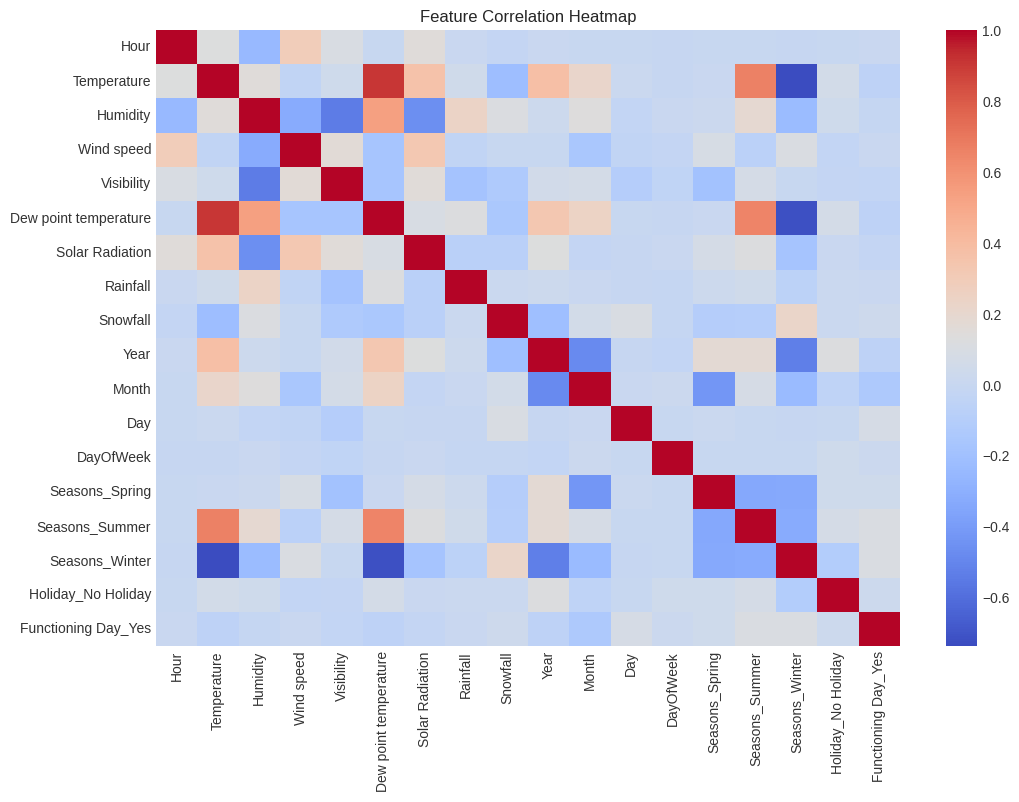

In [14]:
X_train_df = pd.DataFrame(X_train, columns=X_train.columns)

correlation_matrix = X_train_df.corr()

plt.figure(figsize=(12, 8))
# calculated correlation matrix in the heatmap
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=False, fmt='.2f')
plt.title("Feature Correlation Heatmap")
plt.show()

In [15]:
# Function to calculate VIF (Variance Inflation Factor)
def calculate_vif(X):
    # Select only numeric columns to avoid issues with non-numeric data types
    X_numeric = X.select_dtypes(include=np.number)
    # Drop columns with any non-finite values if they exist (though the type error suggests something else)
    # X_numeric = X_numeric.replace([np.inf, -np.inf], np.nan).dropna(axis=1)

    # Check if there are still columns left
    if X_numeric.shape[1] == 0:
        print("Warning: No numeric columns found for VIF calculation.")
        return pd.DataFrame(columns=["feature", "VIF"])

    vif_data = pd.DataFrame()
    vif_data["feature"] = X_numeric.columns
    # Ensure the values passed to variance_inflation_factor are finite and the correct type
    vif_data["VIF"] = [variance_inflation_factor(X_numeric.values, i) for i in range(X_numeric.shape[1])]
    return vif_data.sort_values("VIF", ascending=False)

# Function to remove collinear features based on correlation threshold
def remove_collinear_features(X, threshold=0.8):
    # Select only numeric columns before calculating correlation
    X_numeric = X.select_dtypes(include=np.number)

    corr_matrix = X_numeric.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    # Plot correlation matrix
    plt.figure(figsize=(12, 10))
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    sns.heatmap(corr_matrix, mask=mask, cmap='coolwarm', annot=False,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})
    plt.title('Feature Correlation Matrix')
    plt.tight_layout()
    plt.savefig('correlation_matrix.png')
    plt.show()

    # Find features with correlation greater than threshold
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

    print(f"Dropping {len(to_drop)} collinear features: {', '.join(to_drop)}")

    # Return dataframe with collinear features removed (applied to original X)
    return X.drop(to_drop, axis=1)


Variance Inflation Factors before colinearity removal:
                  feature         VIF
9                    Year  400.077937
1             Temperature  187.639650
2                Humidity  185.135619
5   Dew point temperature  124.905908
4              Visibility   10.741240
10                  Month    5.127716
3              Wind speed    4.870599
0                    Hour    4.490694
11                    Day    4.365954
12              DayOfWeek    3.316688


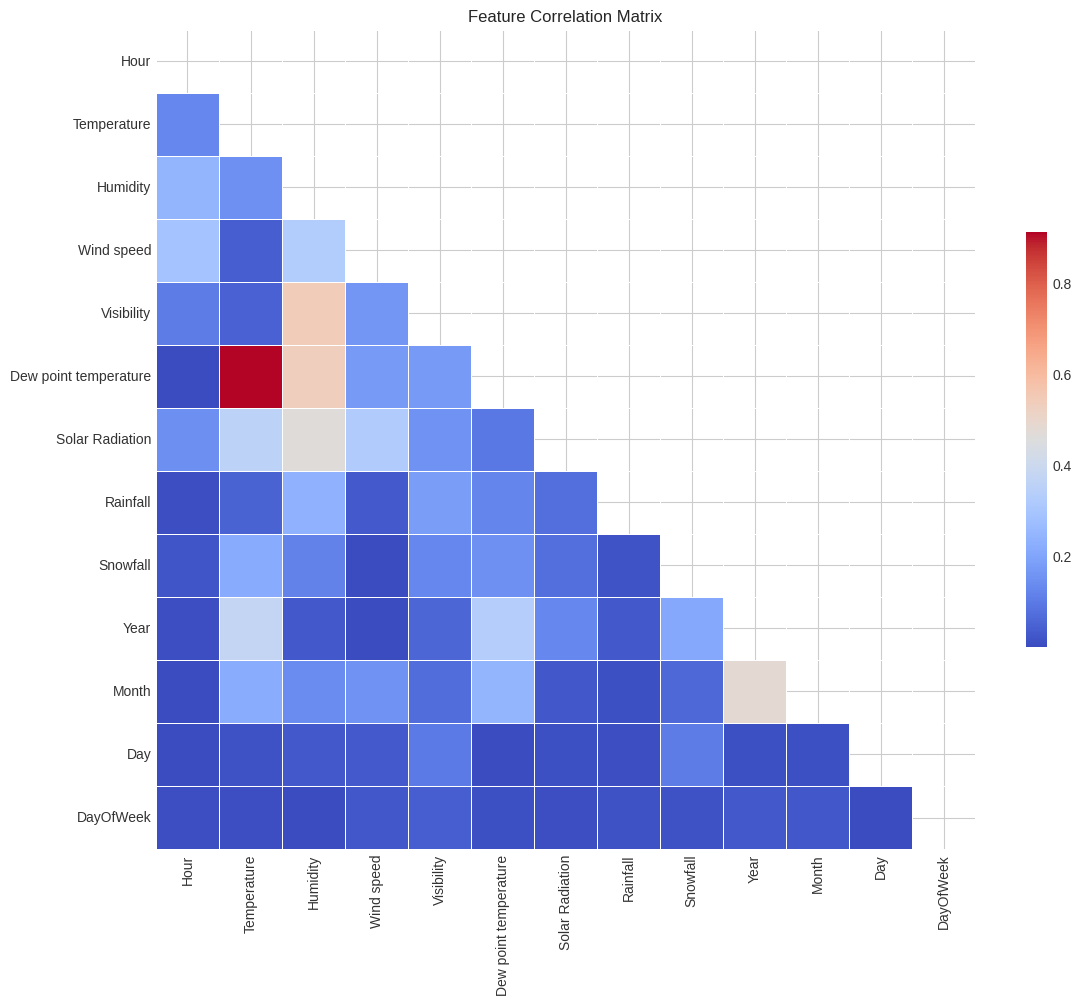

Dropping 1 collinear features: Dew point temperature

Variance Inflation Factors after collinearity removal:
            feature        VIF
8              Year  65.515521
2          Humidity  23.627670
4        Visibility  10.684063
9             Month   5.127686
3        Wind speed   4.862055
0              Hour   4.481881
10              Day   4.365509
1       Temperature   3.659379
11        DayOfWeek   3.293785
5   Solar Radiation   2.770306


In [16]:
# Calculate VIF before feature removal
print("Variance Inflation Factors before colinearity removal:")
# Ensure only numeric columns are passed to calculate_vif
X_train_numeric = X_train.select_dtypes(include=np.number)
vif_before = calculate_vif(X_train_numeric)
print(vif_before.head(10))  # Show top 10 highest VIF values

# Remove collinear features
# The remove_collinear_features function now handles numeric selection internally for correlation
X_train_filtered = remove_collinear_features(X_train, threshold=0.8)
# Ensure test set has the same columns as the filtered training set
X_test_filtered = X_test[X_train_filtered.columns]

# Save feature names for later use in feature importance plots
feature_names = X_train_filtered.columns.tolist()

# Calculate VIF after feature removal
print("\nVariance Inflation Factors after collinearity removal:")
# Ensure only numeric columns are passed to calculate_vif
X_train_filtered_numeric = X_train_filtered.select_dtypes(include=np.number)
vif_after = calculate_vif(X_train_filtered_numeric)
print(vif_after.head(10))

In [17]:
# Standardize the filtered features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_filtered)
X_test_scaled = scaler.transform(X_test_filtered)

# **Dictionary and helper functions to store and compare model results**
Dictionary to store metrics from each model to make it easier to compare at the end.

In [18]:
# Initialize results dictionary to store all model performance metrics
model_results = {
    'Model': [],
    'R²_Train': [],
    'R²_Test': [],
    'RMSE_Train': [],
    'RMSE_Test': [],
    'MAE_Train': [],
    'MAE_Test': [],
    'Notes': [],
    'Trained_Model': []
}

# Add key to store each model in the dictionary
model_results['Trained_Model'] = []

def calculate_metrics(y_true, y_pred):
    """
    Calculate R², RMSE, and MAE for given true and predicted values

    Parameters:
    y_true: actual values
    y_pred: predicted values

    Returns:
    dict with R², RMSE, and MAE
    """
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)

    return {
        'R²': r2,
        'RMSE': rmse,
        'MAE': mae
    }

def add_model_results(model_name, y_train_true, y_train_pred, y_test_true, y_test_pred, notes=""):
    """
    Add model results to the tracking dictionary

    Parameters:
    model_name: string name of the model
    y_train_true: actual training values
    y_train_pred: predicted training values
    y_test_true: actual test values
    y_test_pred: predicted test values
    notes: optional notes about the model
    """

    # Calculate metrics for training set
    train_metrics = calculate_metrics(y_train_true, y_train_pred)

    # Calculate metrics for test set
    test_metrics = calculate_metrics(y_test_true, y_test_pred)

    # Add to results dictionary
    model_results['Model'].append(model_name)
    model_results['R²_Train'].append(train_metrics['R²'])
    model_results['R²_Test'].append(test_metrics['R²'])
    model_results['RMSE_Train'].append(train_metrics['RMSE'])
    model_results['RMSE_Test'].append(test_metrics['RMSE'])
    model_results['MAE_Train'].append(train_metrics['MAE'])
    model_results['MAE_Test'].append(test_metrics['MAE'])
    model_results['Notes'].append(notes)
    model_results['Trained_Model'].append(None)


def display_results_table():
    """
    Display results as a formatted DataFrame
    """
    results_df = pd.DataFrame(model_results)

    if len(results_df) == 0:
        print("No model results to display yet.")
        return None

    # Remove Trained_Model column from display
    display_df = results_df.drop('Trained_Model', axis=1, errors='ignore')

    # Round numerical columns for better display
    numerical_cols = ['R²_Train', 'R²_Test', 'RMSE_Train', 'RMSE_Test', 'MAE_Train', 'MAE_Test']
    for col in numerical_cols:
        results_df[col] = results_df[col].round(4)

    return results_df

def display_simplified_results_table():
    """
    Display a simplified results table with only key test metrics
    Shows: Model, Test R², Test RMSE, Test MAE, Notes
    """
    results_df = pd.DataFrame(model_results)

    if len(results_df) == 0:
        print("No model results to display yet.")
        return None

    # Select only the test columns
    simplified_df = results_df[['Model', 'R²_Test', 'RMSE_Test', 'MAE_Test', 'Notes']].copy()

    # Round numerical columns for better display
    simplified_df['R²_Test'] = simplified_df['R²_Test'].round(4)
    simplified_df['RMSE_Test'] = simplified_df['RMSE_Test'].round(2)
    simplified_df['MAE_Test'] = simplified_df['MAE_Test'].round(2)

    # Sort by Test R² (descending) to show best models first
    simplified_df = simplified_df.sort_values('R²_Test', ascending=False)

    # Reset index for clean display
    simplified_df = simplified_df.reset_index(drop=True)

    return simplified_df


def get_best_model():
    """
    Identify the best performing model based on test R²
    """
    if len(model_results['Model']) == 0:
        print("No model results available yet.")
        return None

    results_df = pd.DataFrame(model_results)
    best_idx = results_df['R²_Test'].idxmax()
    best_model = results_df.loc[best_idx]

    print(f"\nBest Model (highest test R²): {best_model['Model']}")
    print(f"Test R²: {best_model['R²_Test']:.4f}")
    print(f"Test RMSE: {best_model['RMSE_Test']:.4f}")
    print(f"Test MAE: {best_model['MAE_Test']:.4f}")

    return best_model

def add_model_results_with_model(model_name, model, y_train_true, y_train_pred, y_test_true, y_test_pred, notes=""):
    """
    Enhanced version that also saves the trained model

    Parameters:
    model_name: string name of the model
    model: the actual trained model object
    y_train_true: actual training values
    y_train_pred: predicted training values
    y_test_true: actual test values
    y_test_pred: predicted test values
    notes: optional notes about the model
    """

    # Calculate metrics for training set
    train_metrics = calculate_metrics(y_train_true, y_train_pred)

    # Calculate metrics for test set
    test_metrics = calculate_metrics(y_test_true, y_test_pred)

    # Add to results dictionary
    model_results['Model'].append(model_name)
    model_results['R²_Train'].append(train_metrics['R²'])
    model_results['R²_Test'].append(test_metrics['R²'])
    model_results['RMSE_Train'].append(train_metrics['RMSE'])
    model_results['RMSE_Test'].append(test_metrics['RMSE'])
    model_results['MAE_Train'].append(train_metrics['MAE'])
    model_results['MAE_Test'].append(test_metrics['MAE'])
    model_results['Notes'].append(notes)
    model_results['Trained_Model'].append(model)

def get_model_by_name(model_name):
    """
    Retrieve a trained model by name

    Parameters:
    model_name: string name of the model

    Returns:
    trained model object or None if not found
    """
    try:
        results_df = pd.DataFrame(model_results)
        model_idx = results_df[results_df['Model'] == model_name].index[0]
        return model_results['Trained_Model'][model_idx]
    except:
        print(f"Model '{model_name}' not found in results")
        return None

# **Baseline Model**

In [19]:
# Baseline XGBoost model
print("Training baseline XGBoost regression model...")
baseline_model = xgb.XGBRegressor(random_state=42)
baseline_model.fit(X_train_scaled, y_train.values.ravel())

# Get predictions for both training and test sets
baseline_train_preds = baseline_model.predict(X_train_scaled)
baseline_test_preds = baseline_model.predict(X_test_scaled)

# Add results with model saving (only if not already added)
model_name = "XGBoost Baseline"
if model_name not in model_results['Model']:
    add_model_results_with_model(
        model_name=model_name,
        model=baseline_model,  # Save the actual model
        y_train_true=y_train.values.ravel(),
        y_train_pred=baseline_train_preds,
        y_test_true=y_test.values.ravel(),
        y_test_pred=baseline_test_preds,
        notes="Default XGBoost parameters, VIF removal"
    )

# Display current results
display_results_table()

Training baseline XGBoost regression model...


,Model,R²_Train,R²_Test,RMSE_Train,RMSE_Test,MAE_Train,MAE_Test,Notes,Trained_Model
0,XGBoost Baseline,0.9883,0.9364,69.7798,162.7383,45.7172,96.8159,"Default XGBoost parameters, VIF removal","XGBRegressor(base_score=None, booster=None, ca..."


# **Optimal XGBoost Model**

In [20]:
# Uncomment below to run grid search, not necessary every time but used to find optimal XGBoost parameters

# print("Starting XGBoost Grid Search...")
# print("This will take 5-10 minutes. Only run when needed!")

# # FAST Parameter grid - focused on most impactful parameters
# param_grid_vif = {
#     # Learning rates - most critical parameter
#     'learning_rate': [0.03, 0.05, 0.08],

#     # Tree depth - key for complexity
#     'max_depth': [5, 6, 7],

#     # Number of estimators - moderate range
#     'n_estimators': [250, 350],

#     # Regularization - most effective combo
#     'reg_alpha': [1.0, 2.0],
#     'reg_lambda': [2.0, 3.0],

#     # Keep other params fixed at good defaults
#     'min_child_weight': [3],
#     'subsample': [0.8],
#     'colsample_bytree': [0.8]
# }

# print(f"Parameter combinations: {np.prod([len(v) for v in param_grid_vif.values()])}")
# print("Target: Beat R² = 0.943 benchmark with VIF preprocessing")

# # Time Series Cross-Validation
# tscv = TimeSeriesSplit(n_splits=5, test_size=len(X_train_scaled)//8)
# print("Using TimeSeriesSplit to respect temporal order")

# # XGBoost for grid search
# xgb_search = xgb.XGBRegressor(
#     random_state=42,
#     n_jobs=-1,
#     verbosity=0,
#     objective='reg:squarederror',
#     eval_metric='rmse'
# )

# # Grid Search
# grid_search = GridSearchCV(
#     estimator=xgb_search,
#     param_grid=param_grid_vif,
#     cv=tscv,
#     scoring='r2',
#     n_jobs=-1,
#     verbose=1,
#     return_train_score=True
# )

# # Run the search
# print("Starting grid search...")
# grid_search.fit(X_train_scaled, y_train.values.ravel())
# print("Grid search completed!")

# # Extract and display results
# best_params = grid_search.best_params_
# best_cv_score = grid_search.best_score_

# print(f"\nBest Parameters:")
# print("-" * 30)
# for param, value in best_params.items():
#     print(f"{param:18s}: {value}")

In [21]:
# XGBoost with Hard-Coded Optimal Parameters from Grid Search
print("Training XGBoost with optimal parameters from grid search...")

# Hard-coded optimal parameters from grid search
optimal_xgb_model = xgb.XGBRegressor(
    learning_rate=0.08,
    max_depth=7,
    n_estimators=350,
    min_child_weight=3,
    reg_alpha=2.0,
    reg_lambda=2.0,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    verbosity=0
)

print("Parameters used:")
print(f"  learning_rate: 0.08")
print(f"  max_depth: 7")
print(f"  n_estimators: 350")
print(f"  min_child_weight: 3")
print(f"  reg_alpha: 2.0")
print(f"  reg_lambda: 2.0")
print(f"  subsample: 0.8")
print(f"  colsample_bytree: 0.8")

# Train the model
optimal_xgb_model.fit(X_train_scaled, y_train.values.ravel())

# Get predictions for both training and test sets
optimal_train_preds = optimal_xgb_model.predict(X_train_scaled)
optimal_test_preds = optimal_xgb_model.predict(X_test_scaled)

model_name = "XGBoost Optimal (Grid Search)"
if model_name not in model_results['Model']:
    add_model_results_with_model(
        model_name=model_name,
        model=optimal_xgb_model,
        y_train_true=y_train.values.ravel(),
        y_train_pred=optimal_train_preds,
        y_test_true=y_test.values.ravel(),
        y_test_pred=optimal_test_preds,
        notes="Grid search optimized"
    )

display_results_table()

Training XGBoost with optimal parameters from grid search...
Parameters used:
  learning_rate: 0.08
  max_depth: 7
  n_estimators: 350
  min_child_weight: 3
  reg_alpha: 2.0
  reg_lambda: 2.0
  subsample: 0.8
  colsample_bytree: 0.8


,Model,R²_Train,R²_Test,RMSE_Train,RMSE_Test,MAE_Train,MAE_Test,Notes,Trained_Model
0,XGBoost Baseline,0.9883,0.9364,69.7798,162.7383,45.7172,96.8159,"Default XGBoost parameters, VIF removal","XGBRegressor(base_score=None, booster=None, ca..."
1,XGBoost Optimal (Grid Search),0.9947,0.9518,46.7708,141.6577,30.5316,81.3220,Grid search optimized,"XGBRegressor(base_score=None, booster=None, ca..."


# **Cluster Models Development Using K-Means**

In [22]:
# Euclidean K-means clustering
print("Performing Euclidean K-means clustering...")
euclidean_kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
euclidean_clusters = euclidean_kmeans.fit_predict(X_train_scaled)

Performing Euclidean K-means clustering...


In [23]:
# Mahalanobis K-means clustering
print("Performing Mahalanobis distance-based clustering...")
# Calculate covariance matrix
cov = np.cov(X_train_scaled, rowvar=False)
# Add small value to diagonal to ensure matrix is invertible
cov += np.eye(cov.shape[0]) * 1e-6
inv_cov = np.linalg.inv(cov)

Performing Mahalanobis distance-based clustering...


In [24]:
# Function to calculate Mahalanobis distance
def mahalanobis_distance(x, y, inv_cov):
    return mahalanobis(x, y, inv_cov)


In [25]:
# Custom K-means with Mahalanobis distance
# Initialize with Euclidean K-means
mahalanobis_clusters = euclidean_kmeans.predict(X_train_scaled)

# Refine clusters using Mahalanobis distance
centroids = np.array([X_train_scaled[mahalanobis_clusters == i].mean(axis=0) for i in range(3)])
for _ in range(5):  # Limited iterations for simplicity
    # Assign points to nearest centroid using Mahalanobis distance
    mahalanobis_clusters = np.zeros(len(X_train_scaled), dtype=int)
    for i, point in enumerate(X_train_scaled):
        distances = [mahalanobis_distance(point, centroid, inv_cov) for centroid in centroids]
        mahalanobis_clusters[i] = np.argmin(distances)

    # Update centroids
    for i in range(3):
        if sum(mahalanobis_clusters == i) > 0:
            centroids[i] = X_train_scaled[mahalanobis_clusters == i].mean(axis=0)

In [26]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
import numpy as np
import xgboost as xgb

def train_cluster_specific_models(X_train_scaled, y_train, clusters, cluster_type='Euclidean'):
    models = []

    # Hyperparameter search space
    param_dist = {
        'n_estimators': randint(50, 300),
        'max_depth': randint(3, 10),
        'learning_rate': uniform(0.01, 0.3),
        'subsample': uniform(0.6, 0.4),
        'colsample_bytree': uniform(0.5, 0.5),
        'min_child_weight': randint(1, 5)
    }

    for i in range(3):
        # Find indices for current cluster
        cluster_indices = clusters == i

        # Check if cluster has samples
        if sum(cluster_indices) > 0:
            print(f"Training {cluster_type} cluster {i} model with {sum(cluster_indices)} samples")

            # Prepare cluster-specific data
            X_cluster = X_train_scaled[cluster_indices]
            y_cluster = y_train.iloc[cluster_indices].values.ravel()

            # Base XGBoost model
            base_model = xgb.XGBRegressor(
                random_state=42,
                n_jobs=-1,  # Use all cores
                objective='reg:squarederror'
            )

            # Randomized Search with Cross-Validation
            random_search = RandomizedSearchCV(
                estimator=base_model,
                param_distributions=param_dist,
                n_iter=50,  # Number of parameter settings sampled
                cv=5,  # 5-fold cross-validation
                scoring='neg_mean_squared_error',
                random_state=42,
                verbose=1
            )

            # Fit the randomized search
            random_search.fit(X_cluster, y_cluster)

            # Best model
            best_model = random_search.best_estimator_

            # Print best parameters and score
            print(f"Best parameters for cluster {i}:")
            print(random_search.best_params_)
            print(f"Best CV Score: {-random_search.best_score_:.4f}")

            models.append(best_model)
        else:
            models.append(None)

    return models

# Train models with hyperparameter tuning
euclidean_models = train_cluster_specific_models(
    X_train_scaled,
    y_train,
    euclidean_clusters,
    cluster_type='Euclidean'
)

mahalanobis_models = train_cluster_specific_models(
    X_train_scaled,
    y_train,
    mahalanobis_clusters,
    cluster_type='Mahalanobis'
)

Training Euclidean cluster 0 model with 1790 samples
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters for cluster 0:
{'colsample_bytree': np.float64(0.8641081743059298), 'learning_rate': np.float64(0.12033493981577596), 'max_depth': 6, 'min_child_weight': 2, 'n_estimators': 247, 'subsample': np.float64(0.7595297769778212)}
Best CV Score: 32840.6469
Training Euclidean cluster 1 model with 3491 samples
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters for cluster 1:
{'colsample_bytree': np.float64(0.9868777594207296), 'learning_rate': np.float64(0.07983140212909126), 'max_depth': 8, 'min_child_weight': 3, 'n_estimators': 239, 'subsample': np.float64(0.6798695128633439)}
Best CV Score: 25498.6551
Training Euclidean cluster 2 model with 1727 samples
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters for cluster 2:
{'colsample_bytree': np.float64(0.9478817978367597), 'learning_rate': np.float64(0.15261106695

In [27]:
euclidean_models

[XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=np.float64(0.8641081743059298), device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=np.float64(0.12033493981577596), max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=2, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=247, n_jobs=-1,
              num_parallel_tree=None, random_state=42, ...),
 XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=np.float64(0.9868777594207296), 

In [28]:
mahalanobis_models

[XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=np.float64(0.8641081743059298), device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=np.float64(0.12033493981577596), max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=2, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=247, n_jobs=-1,
              num_parallel_tree=None, random_state=42, ...),
 XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=np.float64(0.9868777594207296), 

In [29]:
# Predict test set clusters
euclidean_test_clusters = euclidean_kmeans.predict(X_test_scaled)
mahalanobis_test_clusters = np.zeros(len(X_test_scaled), dtype=int)
for i, point in enumerate(X_test_scaled):
    distances = [mahalanobis_distance(point, centroid, inv_cov) for centroid in centroids]
    mahalanobis_test_clusters[i] = np.argmin(distances)

In [30]:
# Make predictions using cluster-specific models
print("Making predictions with cluster-specific models...")

# Initialize prediction arrays
euclidean_train_preds = np.zeros(len(y_train))
euclidean_test_preds = np.zeros(len(y_test))
mahalanobis_train_preds = np.zeros(len(y_train))
mahalanobis_test_preds = np.zeros(len(y_test))

# Generate predictions for each cluster
for i in range(3):
    # Euclidean cluster predictions
    # Training predictions
    train_cluster_indices = euclidean_clusters == i
    if sum(train_cluster_indices) > 0 and euclidean_models[i] is not None:
        euclidean_train_preds[train_cluster_indices] = euclidean_models[i].predict(X_train_scaled[train_cluster_indices])

    # Test predictions
    test_cluster_indices = euclidean_test_clusters == i
    if sum(test_cluster_indices) > 0 and euclidean_models[i] is not None:
        euclidean_test_preds[test_cluster_indices] = euclidean_models[i].predict(X_test_scaled[test_cluster_indices])

    # Mahalanobis cluster predictions
    # Training predictions
    train_cluster_indices = mahalanobis_clusters == i
    if sum(train_cluster_indices) > 0 and mahalanobis_models[i] is not None:
        mahalanobis_train_preds[train_cluster_indices] = mahalanobis_models[i].predict(X_train_scaled[train_cluster_indices])

    # Test predictions
    test_cluster_indices = mahalanobis_test_clusters == i
    if sum(test_cluster_indices) > 0 and mahalanobis_models[i] is not None:
        mahalanobis_test_preds[test_cluster_indices] = mahalanobis_models[i].predict(X_test_scaled[test_cluster_indices])



Making predictions with cluster-specific models...


In [31]:
# Add model results to dictionary
add_model_results(
    model_name="Cluster-Specific Euclidean",
    y_train_true=y_train.values.ravel(),
    y_train_pred=euclidean_train_preds,  # Use correct variables
    y_test_true=y_test.values.ravel(),
    y_test_pred=euclidean_test_preds,
    notes="Euclidean clustering + XGBoost"
)

add_model_results(
    model_name="Cluster-Specific Mahalanobis",
    y_train_true=y_train.values.ravel(),
    y_train_pred=mahalanobis_train_preds,  # Use correct variables
    y_test_true=y_test.values.ravel(),
    y_test_pred=mahalanobis_test_preds,
    notes="Mahalanobis clustering + XGBoost"
)

# Display updated results
display_results_table()

,Model,R²_Train,R²_Test,RMSE_Train,RMSE_Test,MAE_Train,MAE_Test,Notes,Trained_Model
0,XGBoost Baseline,0.9883,0.9364,69.7798,162.7383,45.7172,96.8159,"Default XGBoost parameters, VIF removal","XGBRegressor(base_score=None, booster=None, ca..."
1,XGBoost Optimal (Grid Search),0.9947,0.9518,46.7708,141.6577,30.5316,81.3220,Grid search optimized,"XGBRegressor(base_score=None, booster=None, ca..."
2,Cluster-Specific Euclidean,0.9989,0.9471,21.1500,148.4179,13.6329,79.7423,Euclidean clustering + XGBoost,None
3,Cluster-Specific Mahalanobis,0.9990,0.9509,20.6803,142.9966,13.8583,77.9614,Mahalanobis clustering + XGBoost,None


# **Neural Network Model Developement**

In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Define the neural network model
def build_neural_network(input_dim):
    model = Sequential()
    model.add(Dense(128, input_dim=input_dim, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='linear'))
    return model

# Build the model
input_dim = X_train_scaled.shape[1]
neural_network_model = build_neural_network(input_dim)

# Compile the model
neural_network_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = neural_network_model.fit(
    X_train_scaled, y_train,
    validation_data=(X_test_scaled, y_test),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

# Save the model
neural_network_model.save('best_seoul_bike_model.h5')

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 757194.8750 - mae: 621.3089 - val_loss: 179571.8125 - val_mae: 296.0500
Epoch 2/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 168051.6406 - mae: 288.7932 - val_loss: 167199.3438 - val_mae: 277.9908
Epoch 3/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 158208.5312 - mae: 274.9282 - val_loss: 163963.2031 - val_mae: 277.1498
Epoch 4/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 158175.8906 - mae: 274.3506 - val_loss: 161069.6875 - val_mae: 272.8971
Epoch 5/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 156894.7656 - mae: 271.1060 - val_loss: 156943.5625 - val_mae: 267.1017
Epoch 6/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 149477.3281 - mae: 263.3114 - val_loss: 155106.3125 - val_mae: 262.8690
Epoch 7/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 149549.2031 - mae: 264.3340 - val_loss: 154051.2344 - val_mae: 258.8243
Epoch 8/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 148263.3438 - mae: 2

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


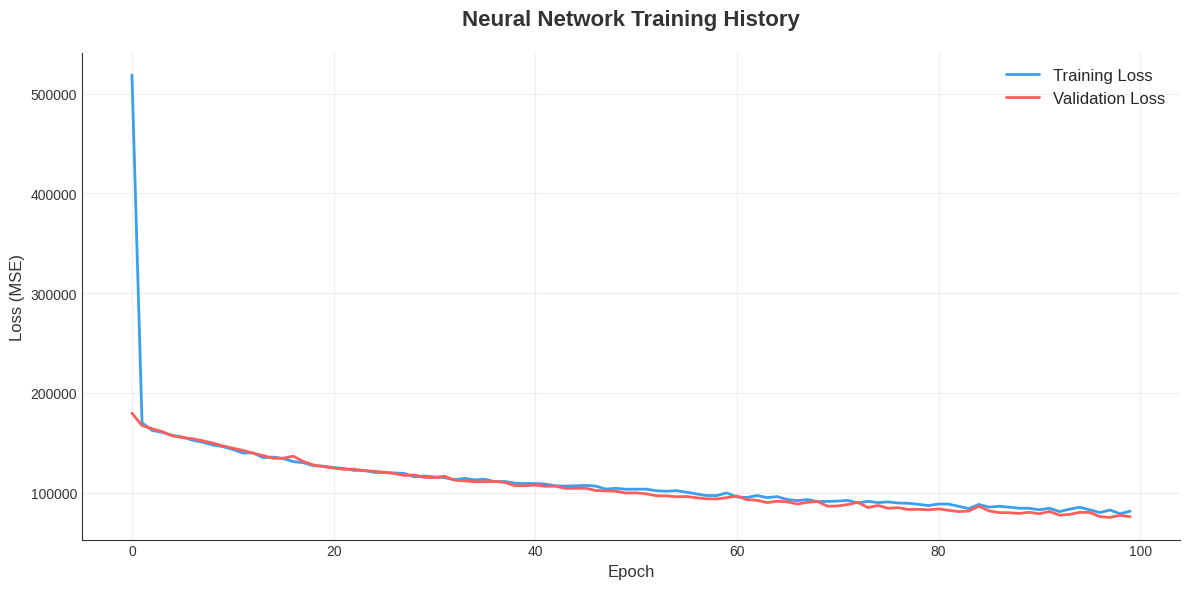

,Model,R²_Train,R²_Test,RMSE_Train,RMSE_Test,MAE_Train,MAE_Test,Notes,Trained_Model
0,XGBoost Baseline,0.9883,0.9364,69.7798,162.7383,45.7172,96.8159,"Default XGBoost parameters, VIF removal","XGBRegressor(base_score=None, booster=None, ca..."
1,XGBoost Optimal (Grid Search),0.9947,0.9518,46.7708,141.6577,30.5316,81.3220,Grid search optimized,"XGBRegressor(base_score=None, booster=None, ca..."
2,Cluster-Specific Euclidean,0.9989,0.9471,21.1500,148.4179,13.6329,79.7423,Euclidean clustering + XGBoost,None
3,Cluster-Specific Mahalanobis,0.9990,0.9509,20.6803,142.9966,13.8583,77.9614,Mahalanobis clustering + XGBoost,None
4,Neural Network,0.8543,0.8199,246.1619,273.9148,157.8762,171.5171,Neural network with 3 hidden layers and dropout,None


In [33]:
# Evaluate the neural network model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Make predictions using the neural network model
nn_train_preds = neural_network_model.predict(X_train_scaled)
nn_test_preds = neural_network_model.predict(X_test_scaled)

# Calculate metrics for the neural network model
nn_metrics = {
    'rmse_train': np.sqrt(mean_squared_error(y_train, nn_train_preds)),
    'rmse_test': np.sqrt(mean_squared_error(y_test, nn_test_preds)),
    'mae_train': mean_absolute_error(y_train, nn_train_preds),
    'mae_test': mean_absolute_error(y_test, nn_test_preds),
    'r2_train': r2_score(y_train, nn_train_preds),
    'r2_test': r2_score(y_test, nn_test_preds)
}

# Add neural network results to the tracking system
add_model_results(
    model_name="Neural Network",
    y_train_true=y_train.values.ravel(),
    y_train_pred=nn_train_preds.ravel(),
    y_test_true=y_test.values.ravel(),
    y_test_pred=nn_test_preds.ravel(),
    notes="Neural network with 3 hidden layers and dropout"
)

# Visualize the training history
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss', color='#39A0ED', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', color='#FF5E5B', linewidth=2)
plt.title('Neural Network Training History', fontsize=16, pad=20, fontweight='bold', color='#333333')
plt.xlabel('Epoch', fontsize=12, color='#333333')
plt.ylabel('Loss (MSE)', fontsize=12, color='#333333')
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()
plt.savefig('nn_training_history.png', dpi=300, bbox_inches='tight', facecolor='#f8f9fa')
plt.show()

# Display updated results
display_results_table()

# **Random Forest**

In [34]:
# Simple Random Forest with basic parameters
rf_model = RandomForestRegressor(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)

# Train the model
rf_model.fit(X_train_scaled, y_train.values.ravel())

# Get predictions for both training and test sets
rf_train_preds = rf_model.predict(X_train_scaled)
rf_test_preds = rf_model.predict(X_test_scaled)

# Add results to tracking system (only if not already added)
model_name = "Random Forest"
if model_name not in model_results['Model']:
    add_model_results_with_model(
        model_name=model_name,
        model=rf_model,  # Save the actual model
        y_train_true=y_train.values.ravel(),
        y_train_pred=rf_train_preds,
        y_test_true=y_test.values.ravel(),
        y_test_pred=rf_test_preds,
        notes="Simple Random Forest, default parameters"
    )

display_results_table()

,Model,R²_Train,R²_Test,RMSE_Train,RMSE_Test,MAE_Train,MAE_Test,Notes,Trained_Model
0,XGBoost Baseline,0.9883,0.9364,69.7798,162.7383,45.7172,96.8159,"Default XGBoost parameters, VIF removal","XGBRegressor(base_score=None, booster=None, ca..."
1,XGBoost Optimal (Grid Search),0.9947,0.9518,46.7708,141.6577,30.5316,81.3220,Grid search optimized,"XGBRegressor(base_score=None, booster=None, ca..."
2,Cluster-Specific Euclidean,0.9989,0.9471,21.1500,148.4179,13.6329,79.7423,Euclidean clustering + XGBoost,None
3,Cluster-Specific Mahalanobis,0.9990,0.9509,20.6803,142.9966,13.8583,77.9614,Mahalanobis clustering + XGBoost,None
4,Neural Network,0.8543,0.8199,246.1619,273.9148,157.8762,171.5171,Neural network with 3 hidden layers and dropout,None
5,Random Forest,0.9907,0.9287,62.1418,172.3218,35.7815,97.0924,"Simple Random Forest, default parameters","(DecisionTreeRegressor(max_features=1.0, rando..."


# **Seasonwise Model**
To answer whether an XGBoost model trained on each season can perform better than a model trained over all the seasons can perform better, this section develops a seasonwise model.

For this model, we'll need to separate the orignal dataset into sepatate seasons then apply all the preprocessing steps we did for the other models.  The Seoul Bike Sharing dataset begins in Fall, so we don't use traditional seasonal split dates, we adopt the separation preposed by Shruthi V E and Yongyun Cho. in their paper:

In [35]:
def seasonal_train_test_split(X_original, y_original, test_size=0.2, random_state=42):
    """
    Create seasonal splits using the exact methodology from the research paper:
    - Winter: 1 Dec 2017 - 28 Feb 2018
    - Spring: 1 Mar 2018 - 31 May 2018
    - Summer: 1 Jun 2018 - 31 Aug 2018
    - Autumn: 1 Sep 2018 - 30 Nov 2018

    Parameters:
    X_original: Original features dataframe (before one-hot encoding)
    y_original: Original target
    test_size: proportion for test set (within each season)
    random_state: for reproducibility

    Returns:
    Dictionary with seasonal splits matching the paper's methodology
    """

    if 'Rented Bike Count' in X_original.columns:
        # Make 'Rented Bike Count' the new target
        y = X_original[['Rented Bike Count']]
        # Remove 'Rented Bike Count' from features
        X = X_original.drop('Rented Bike Count', axis=1)
        # Add original target to features
        X = pd.concat([X, y_original], axis=1)
        df = X.copy()
        df['Rented Bike Count'] = y
        target_col = 'Rented Bike Count'
    else:
        y = y_original
        X = X_original
        df = X.copy()
        df['Rented Bike Count'] = y
        target_col = 'Rented Bike Count'

    # Convert date column
    df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')

    # Define the paper's exact seasonal date ranges
    seasonal_ranges = {
        'Winter': {
            'start': pd.to_datetime('2017-12-01'),
            'end': pd.to_datetime('2018-02-28')
        },
        'Spring': {
            'start': pd.to_datetime('2018-03-01'),
            'end': pd.to_datetime('2018-05-31')
        },
        'Summer': {
            'start': pd.to_datetime('2018-06-01'),
            'end': pd.to_datetime('2018-08-31')
        },
        'Autumn': {
            'start': pd.to_datetime('2018-09-01'),
            'end': pd.to_datetime('2018-11-30')
        }
    }

    # Filter and split data for each season
    seasonal_splits = {}

    for season, date_range in seasonal_ranges.items():
        start_date = date_range['start']
        end_date = date_range['end']

        # Filter data for this season's date range
        season_mask = (df['Date'] >= start_date) & (df['Date'] <= end_date)
        season_data = df[season_mask].copy()

        if len(season_data) == 0:
            continue

        # Prepare features and target
        feature_cols = [col for col in season_data.columns if col not in [target_col, 'Date']]
        X_season = season_data[feature_cols]
        y_season = season_data[target_col]

        # Create train/test split for this season
        X_train_season, X_test_season, y_train_season, y_test_season = train_test_split(
            X_season, y_season,
            test_size=test_size,
            random_state=random_state
        )

        # Store the split
        seasonal_splits[season] = {
            'X_train_raw': X_train_season,
            'X_test_raw': X_test_season,
            'y_train': y_train_season,
            'y_test': y_test_season
        }

    return seasonal_splits

def preprocess_seasonal_data(seasonal_splits):
    """
    Apply preprocessing (categorical encoding, VIF removal, scaling) to each season

    Parameters:
    seasonal_splits: Output from seasonal_train_test_split

    Returns:
    Dictionary with fully preprocessed seasonal data
    """

    def calculate_vif(X):
        X_numeric = X.select_dtypes(include=np.number)
        if X_numeric.shape[1] == 0:
            return pd.DataFrame(columns=["feature", "VIF"])

        vif_data = pd.DataFrame()
        vif_data["feature"] = X_numeric.columns
        vif_data["VIF"] = [variance_inflation_factor(X_numeric.values, i) for i in range(X_numeric.shape[1])]
        return vif_data.sort_values("VIF", ascending=False)

    def remove_collinear_features(X, threshold=0.8):
        X_numeric = X.select_dtypes(include=np.number)
        corr_matrix = X_numeric.corr().abs()
        upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

        to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
        return X.drop(to_drop, axis=1)

    seasonal_processed = {}

    for season, splits in seasonal_splits.items():
        X_train_raw = splits['X_train_raw']
        X_test_raw = splits['X_test_raw']

        # 1. Date processing
        X_train_processed = X_train_raw.copy()
        X_test_processed = X_test_raw.copy()

        if 'Date' in X_train_processed.columns:
            # Process training set
            X_train_processed['Date'] = pd.to_datetime(X_train_processed['Date'], format='%d/%m/%Y')
            X_train_processed['Year'] = X_train_processed['Date'].dt.year
            X_train_processed['Month'] = X_train_processed['Date'].dt.month
            X_train_processed['Day'] = X_train_processed['Date'].dt.day
            X_train_processed['DayOfWeek'] = X_train_processed['Date'].dt.dayofweek
            X_train_processed = X_train_processed.drop('Date', axis=1)

            # Process test set
            X_test_processed['Date'] = pd.to_datetime(X_test_processed['Date'], format='%d/%m/%Y')
            X_test_processed['Year'] = X_test_processed['Date'].dt.year
            X_test_processed['Month'] = X_test_processed['Date'].dt.month
            X_test_processed['Day'] = X_test_processed['Date'].dt.day
            X_test_processed['DayOfWeek'] = X_test_processed['Date'].dt.dayofweek
            X_test_processed = X_test_processed.drop('Date', axis=1)

        # 2. One-hot encode categorical features
        X_train_encoded = pd.get_dummies(X_train_processed, drop_first=True)
        X_test_encoded = pd.get_dummies(X_test_processed, drop_first=True)

        # Align test set columns with training set
        missing_cols = set(X_train_encoded.columns) - set(X_test_encoded.columns)
        for col in missing_cols:
            X_test_encoded[col] = 0
        X_test_encoded = X_test_encoded[X_train_encoded.columns]

        # 3. VIF removal
        X_train_filtered = remove_collinear_features(X_train_encoded, threshold=0.8)
        X_test_filtered = X_test_encoded[X_train_filtered.columns]

        # 4. Scaling
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train_filtered)
        X_test_scaled = scaler.transform(X_test_filtered)

        # Store processed results
        seasonal_processed[season] = {
            'X_train': X_train_scaled,
            'X_test': X_test_scaled,
            'y_train': splits['y_train'],
            'y_test': splits['y_test'],
            'feature_names': list(X_train_filtered.columns),
            'scaler': scaler
        }

    return seasonal_processed

In [36]:
seasonal_splits = seasonal_train_test_split(X_original, y_original)
seasonal_processed = preprocess_seasonal_data(seasonal_splits)

### **Find optimal parameters for each season**

In [37]:
def grid_search_seasonal_xgboost(seasonal_processed, model_results, cv=3, n_jobs=-1, quick_search=True):
    """
    Perform grid search for optimal XGBoost parameters for each season

    Parameters:
    seasonal_processed: Output from preprocess_seasonal_data()
    model_results: Your existing model_results dictionary for tracking
    cv: Number of cross-validation folds
    n_jobs: Number of parallel jobs
    quick_search: If True, use smaller parameter grid for faster results

    Returns:
    Dictionary with optimized seasonal models and their performance
    """

    if quick_search:
        # Faster, focused grid search with known good parameters
        param_grid = {
            'learning_rate': [0.08, 0.1],
            'max_depth': [6, 7, 8],
            'n_estimators': [250, 350],
            'min_child_weight': [3, 5],
            'reg_alpha': [1, 2],
            'reg_lambda': [2, 3],
            'subsample': [0.8],
            'colsample_bytree': [0.8]
        }
        print("Using QUICK grid search (faster, focused parameters)")
    else:
        # Full grid search - more comprehensive but slower
        param_grid = {
            'learning_rate': [0.05, 0.08, 0.1],
            'max_depth': [5, 6, 7, 8],
            'n_estimators': [200, 300, 400],
            'min_child_weight': [1, 3, 5],
            'reg_alpha': [0, 1, 2],
            'reg_lambda': [1, 2, 3],
            'subsample': [0.8, 0.9],
            'colsample_bytree': [0.8, 0.9]
        }
        print("Using FULL grid search (comprehensive but slower)")

    # Calculate total combinations
    total_combinations = 1
    for param_values in param_grid.values():
        total_combinations *= len(param_values)

    print(f"Total parameter combinations to test: {total_combinations}")
    print(f"Estimated time per season: {total_combinations * cv / 60:.1f} minutes")

    # Base XGBoost parameters
    base_params = {
        'random_state': 42,
        'n_jobs': 1,  # Set to 1 since we're parallelizing the grid search
        'verbosity': 0
    }

    seasonal_models = {}

    for season, data in seasonal_processed.items():
        print(f"\n{'='*50}")
        print(f"GRID SEARCH FOR {season.upper()}")
        print(f"{'='*50}")

        # Get the data
        X_train = data['X_train']
        X_test = data['X_test']
        y_train = data['y_train']
        y_test = data['y_test']

        print(f"Training set size: {len(y_train)}")
        print(f"Test set size: {len(y_test)}")
        print(f"Features: {X_train.shape[1]}")

        # Create base model
        xgb_model = xgb.XGBRegressor(**base_params)

        # Perform grid search
        print(f"Running grid search with {cv}-fold CV...")
        import time
        start_time = time.time()

        grid_search = GridSearchCV(
            estimator=xgb_model,
            param_grid=param_grid,
            cv=cv,
            scoring='r2',
            n_jobs=n_jobs,
            verbose=1  # Show progress
        )

        # Fit grid search
        grid_search.fit(X_train, y_train)

        # elapsed_time = time.time() - start_time
        # print(f"Grid search completed in {elapsed_time/60:.1f} minutes")

        # Get best model
        best_model = grid_search.best_estimator_

        print(f"Best CV R² score: {grid_search.best_score_:.4f}")
        print(f"Best parameters:")
        for param, value in grid_search.best_params_.items():
            print(f"  {param}: {value}")

        # Get predictions
        y_train_pred = best_model.predict(X_train)
        y_test_pred = best_model.predict(X_test)

        # Calculate metrics
        train_r2 = r2_score(y_train, y_train_pred)
        test_r2 = r2_score(y_test, y_test_pred)
        train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
        test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
        train_mae = mean_absolute_error(y_train, y_train_pred)
        test_mae = mean_absolute_error(y_test, y_test_pred)

        print(f"\nFinal Performance:")
        print(f"Train R²: {train_r2:.4f}")
        print(f"Test R²: {test_r2:.4f}")
        print(f"Test RMSE: {test_rmse:.2f}")
        print(f"Test MAE: {test_mae:.2f}")

        # Store the model and results
        seasonal_models[season] = {
            'model': best_model,
            'best_params': grid_search.best_params_,
            'cv_score': grid_search.best_score_,
            'train_r2': train_r2,
            'test_r2': test_r2,
            'train_rmse': train_rmse,
            'test_rmse': test_rmse,
            'train_mae': train_mae,
            'test_mae': test_mae,
            'feature_names': data['feature_names'],
            'train_size': len(y_train),
            'test_size': len(y_test),
            'search_time': elapsed_time
        }

        # Add to existing model_results tracking
        model_name = f"XGBoost {season}"
        add_model_results_with_model(
            model_name=model_name,
            model=best_model,
            y_train_true=y_train,
            y_train_pred=y_train_pred,
            y_test_true=y_test,
            y_test_pred=y_test_pred,
            notes=f"Grid search optimized - CV R²: {grid_search.best_score_:.4f}"
        )

    total_time = sum(model['search_time'] for model in seasonal_models.values())
    print(f"\n{'='*50}")
    print(f"TOTAL GRID SEARCH TIME: {total_time/60:.1f} minutes")
    print(f"{'='*50}")

    return seasonal_models

def analyze_seasonal_feature_importance(seasonal_models):
    """
    Analyze and visualize feature importance for each seasonal model

    Parameters:
    seasonal_models: Output from grid_search_seasonal_xgboost()
    """

    print(f"\n{'='*60}")
    print("SEASONAL FEATURE IMPORTANCE ANALYSIS")
    print(f"{'='*60}")

    # Set up the plot
    n_seasons = len(seasonal_models)
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()

    all_features = set()
    feature_importance_df = pd.DataFrame()

    for idx, (season, model_data) in enumerate(seasonal_models.items()):
        model = model_data['model']
        feature_names = model_data['feature_names']

        # Get feature importances
        importances = model.feature_importances_

        # Create DataFrame for this season
        season_df = pd.DataFrame({
            'Feature': feature_names,
            'Importance': importances,
            'Season': season
        }).sort_values('Importance', ascending=False)

        # Add to combined DataFrame
        feature_importance_df = pd.concat([feature_importance_df, season_df])
        all_features.update(feature_names)

        # Plot top 15 features for this season
        top_features = season_df.head(15)

        ax = axes[idx]
        bars = ax.barh(range(len(top_features)), top_features['Importance'])
        ax.set_yticks(range(len(top_features)))
        ax.set_yticklabels(top_features['Feature'], fontsize=8)
        ax.set_xlabel('Feature Importance')
        ax.set_title(f'{season} - Top 15 Features')
        ax.invert_yaxis()

        # Color bars by importance level
        colors = plt.cm.viridis(top_features['Importance'] / top_features['Importance'].max())
        for bar, color in zip(bars, colors):
            bar.set_color(color)

        # Print top 10 features for this season
        print(f"\n{season.upper()} - Top 10 Features:")
        for i, (_, row) in enumerate(top_features.head(10).iterrows(), 1):
            print(f"  {i:2d}. {row['Feature']:<25} {row['Importance']:.4f}")

    plt.tight_layout()
    plt.show()

    # Find features that are consistently important across seasons

    # Calculate average importance across seasons
    avg_importance = feature_importance_df.groupby('Feature')['Importance'].agg([
        'mean', 'std', 'count'
    ]).sort_values('mean', ascending=False)

    # Features important in all seasons
    universal_features = avg_importance[avg_importance['count'] == n_seasons].head(10)
    print(f"\nTop 10 Universal Features (important in all seasons):")
    for i, (feature, row) in enumerate(universal_features.iterrows(), 1):
        print(f"  {i:2d}. {feature:<25} Avg: {row['mean']:.4f} ± {row['std']:.4f}")

    # Features with high variance (season-specific importance)
    variable_features = avg_importance[avg_importance['std'] > 0.01].sort_values('std', ascending=False).head(10)
    print(f"\nTop 10 Season-Specific Features (high variance):")
    for i, (feature, row) in enumerate(variable_features.iterrows(), 1):
        print(f"  {i:2d}. {feature:<25} Avg: {row['mean']:.4f} ± {row['std']:.4f}")

    return feature_importance_df

In [38]:
def train_optimal_seasonal_xgboost_models(seasonal_processed, model_results):
    """
    Train XGBoost models for each season using hard-coded optimal parameters
    (based on your previous grid search results)

    Parameters:
    seasonal_processed: Output from preprocess_seasonal_data()
    model_results: Your existing model_results dictionary for tracking

    Returns:
    Dictionary with trained seasonal models and their performance
    """

    # Hard-coded optimal parameters for each season (from your grid search results)
    seasonal_optimal_params = {
        'Winter': {
            'colsample_bytree': 0.8,
            'learning_rate': 0.05,
            'max_depth': 5,
            'min_child_weight': 10,
            'n_estimators': 250,
            'reg_alpha': 5,
            'reg_lambda': 5,
            'subsample': 0.7,
            'cv_score': 0.6656
        },
        'Spring': {
            'colsample_bytree': 0.8,
            'learning_rate': 0.05,
            'max_depth': 5,
            'min_child_weight': 10,
            'n_estimators': 250,
            'reg_alpha': 5,
            'reg_lambda': 5,
            'subsample': 0.8,
            'cv_score': 0.8198
        },
        'Summer': {
            'colsample_bytree': 0.8,
            'learning_rate': 0.05,
            'max_depth': 5,
            'min_child_weight': 15,
            'n_estimators': 150,
            'reg_alpha': 2,
            'reg_lambda': 5,
            'subsample': 0.7,
            'cv_score': 0.8574
        },
        'Autumn': {
            'colsample_bytree': 0.8,
            'learning_rate': 0.05,
            'max_depth': 5,
            'min_child_weight': 10,
            'n_estimators': 250,
            'reg_alpha': 2,
            'reg_lambda': 5,
            'subsample': 0.7,
            'cv_score': 0.8457
        },
    }

    seasonal_models = {}

    for season, data in seasonal_processed.items():

        # Get the data
        X_train = data['X_train']
        X_test = data['X_test']
        y_train = data['y_train']
        y_test = data['y_test']

        # Get optimal parameters for this season
        params = seasonal_optimal_params[season].copy()
        cv_score = params.pop('cv_score')  # Remove cv_score from model params

        # Create optimized model
        optimal_model = xgb.XGBRegressor(
            **params,
            random_state=42,
            n_jobs=-1,
            verbosity=0
        )

        # Train the model
        optimal_model.fit(X_train, y_train)

        # Get predictions for both training and test sets
        y_train_pred = optimal_model.predict(X_train)
        y_test_pred = optimal_model.predict(X_test)

        # Calculate metrics
        train_r2 = r2_score(y_train, y_train_pred)
        test_r2 = r2_score(y_test, y_test_pred)
        train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
        test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
        train_mae = mean_absolute_error(y_train, y_train_pred)
        test_mae = mean_absolute_error(y_test, y_test_pred)

        # Store the model and results
        seasonal_models[season] = {
            'model': optimal_model,
            'optimal_params': params,
            'cv_score': cv_score,
            'train_r2': train_r2,
            'test_r2': test_r2,
            'train_rmse': train_rmse,
            'test_rmse': test_rmse,
            'train_mae': train_mae,
            'test_mae': test_mae,
            'feature_names': data['feature_names'],
            'train_size': len(y_train),
            'test_size': len(y_test)
        }

        # Add to model_results tracking (only if not already present)
        model_name = f"{season}"
        if model_name not in model_results['Model']:
            add_model_results_with_model(
                model_name=model_name,
                model=optimal_model,
                y_train_true=y_train,
                y_train_pred=y_train_pred,
                y_test_true=y_test,
                y_test_pred=y_test_pred,
                notes=f"Optimal params - CV R²: {cv_score:.4f}"
            )


    return seasonal_models

def add_seasonal_average_to_results(seasonal_models, model_results):
    """
    Calculate and add seasonal average performance to model_results

    Parameters:
    seasonal_models: Output from train_optimal_seasonal_xgboost_models()
    model_results: Your existing model_results dictionary
    """

    # Calculate weighted averages
    total_test_size = sum(model['test_size'] for model in seasonal_models.values())

    # Weighted averages by test set size
    weighted_test_r2 = sum(model['test_r2'] * model['test_size'] for model in seasonal_models.values()) / total_test_size
    weighted_test_rmse = sum(model['test_rmse'] * model['test_size'] for model in seasonal_models.values()) / total_test_size
    weighted_test_mae = sum(model['test_mae'] * model['test_size'] for model in seasonal_models.values()) / total_test_size
    weighted_train_r2 = sum(model['train_r2'] * model['train_size'] for model in seasonal_models.values()) / sum(model['train_size'] for model in seasonal_models.values())

    # Simple averages for comparison
    simple_test_r2 = np.mean([model['test_r2'] for model in seasonal_models.values()])
    simple_cv_score = np.mean([model['cv_score'] for model in seasonal_models.values()])


    # Add to model_results
    model_name = "XGBoost Seasonal (Weighted Average)"
    if model_name not in model_results['Model']:
        model_results['Model'].append(model_name)
        model_results['R²_Train'].append(weighted_train_r2)
        model_results['R²_Test'].append(weighted_test_r2)
        model_results['RMSE_Train'].append(0.0)  # Placeholder
        model_results['RMSE_Test'].append(weighted_test_rmse)
        model_results['MAE_Train'].append(0.0)   # Placeholder
        model_results['MAE_Test'].append(weighted_test_mae)
        model_results['Notes'].append(f"Weighted avg of 4 seasonal models, CV R²: {simple_cv_score:.4f}")
        model_results['Trained_Model'].append(None)

# Train all seasonal models with optimal parameters
seasonal_models = train_optimal_seasonal_xgboost_models(seasonal_processed, model_results)

# Add seasonal average for easy comparison
add_seasonal_average_to_results(seasonal_models, model_results)

display_results_table()

,Model,R²_Train,R²_Test,RMSE_Train,RMSE_Test,MAE_Train,MAE_Test,Notes,Trained_Model
0,XGBoost Baseline,0.9883,0.9364,69.7798,162.7383,45.7172,96.8159,"Default XGBoost parameters, VIF removal","XGBRegressor(base_score=None, booster=None, ca..."
1,XGBoost Optimal (Grid Search),0.9947,0.9518,46.7708,141.6577,30.5316,81.3220,Grid search optimized,"XGBRegressor(base_score=None, booster=None, ca..."
2,Cluster-Specific Euclidean,0.9989,0.9471,21.1500,148.4179,13.6329,79.7423,Euclidean clustering + XGBoost,None
3,Cluster-Specific Mahalanobis,0.9990,0.9509,20.6803,142.9966,13.8583,77.9614,Mahalanobis clustering + XGBoost,None
4,Neural Network,0.8543,0.8199,246.1619,273.9148,157.8762,171.5171,Neural network with 3 hidden layers and dropout,None
5,Random Forest,0.9907,0.9287,62.1418,172.3218,35.7815,97.0924,"Simple Random Forest, default parameters","(DecisionTreeRegressor(max_features=1.0, rando..."
6,Winter,0.8507,0.6668,58.1995,86.1730,37.8616,56.2882,Optimal params - CV R²: 0.6656,"XGBRegressor(base_score=None, booster=None, ca..."
7,Spring,0.9296,0.8423,162.9728,257.3702,114.6575,173.3226,Optimal params - CV R²: 0.8198,"XGBRegressor(base_score=None, booster=None, ca..."
8,Summer,0.9221,0.7587,193.8264,330.1981,134.6378,208.1639,Optimal params - CV R²: 0.8574,"XGBRegressor(base_score=None, booster=None, ca..."
9,Autumn,0.9338,0.8809,166.6105,229.2366,112.1429,154.7970,Optimal params - CV R²: 0.8457,"XGBRegressor(base_score=None, booster=None, ca..."


In [39]:
display_simplified_results_table()

,Model,R²_Test,RMSE_Test,MAE_Test,Notes
0,XGBoost Optimal (Grid Search),0.9518,141.66,81.32,Grid search optimized
1,Cluster-Specific Mahalanobis,0.9509,143.00,77.96,Mahalanobis clustering + XGBoost
2,Cluster-Specific Euclidean,0.9471,148.42,79.74,Euclidean clustering + XGBoost
3,XGBoost Baseline,0.9364,162.74,96.82,"Default XGBoost parameters, VIF removal"
4,Random Forest,0.9287,172.32,97.09,"Simple Random Forest, default parameters"
5,Autumn,0.8809,229.24,154.80,Optimal params - CV R²: 0.8457
6,Spring,0.8423,257.37,173.32,Optimal params - CV R²: 0.8198
7,Neural Network,0.8199,273.91,171.52,Neural network with 3 hidden layers and dropout
8,XGBoost Seasonal (Weighted Average),0.7876,226.53,148.65,"Weighted avg of 4 seasonal models, CV R²: 0.7971"
9,Summer,0.7587,330.20,208.16,Optimal params - CV R²: 0.8574


# **Visualizations**

Generating enhanced 3D PCA visualization...


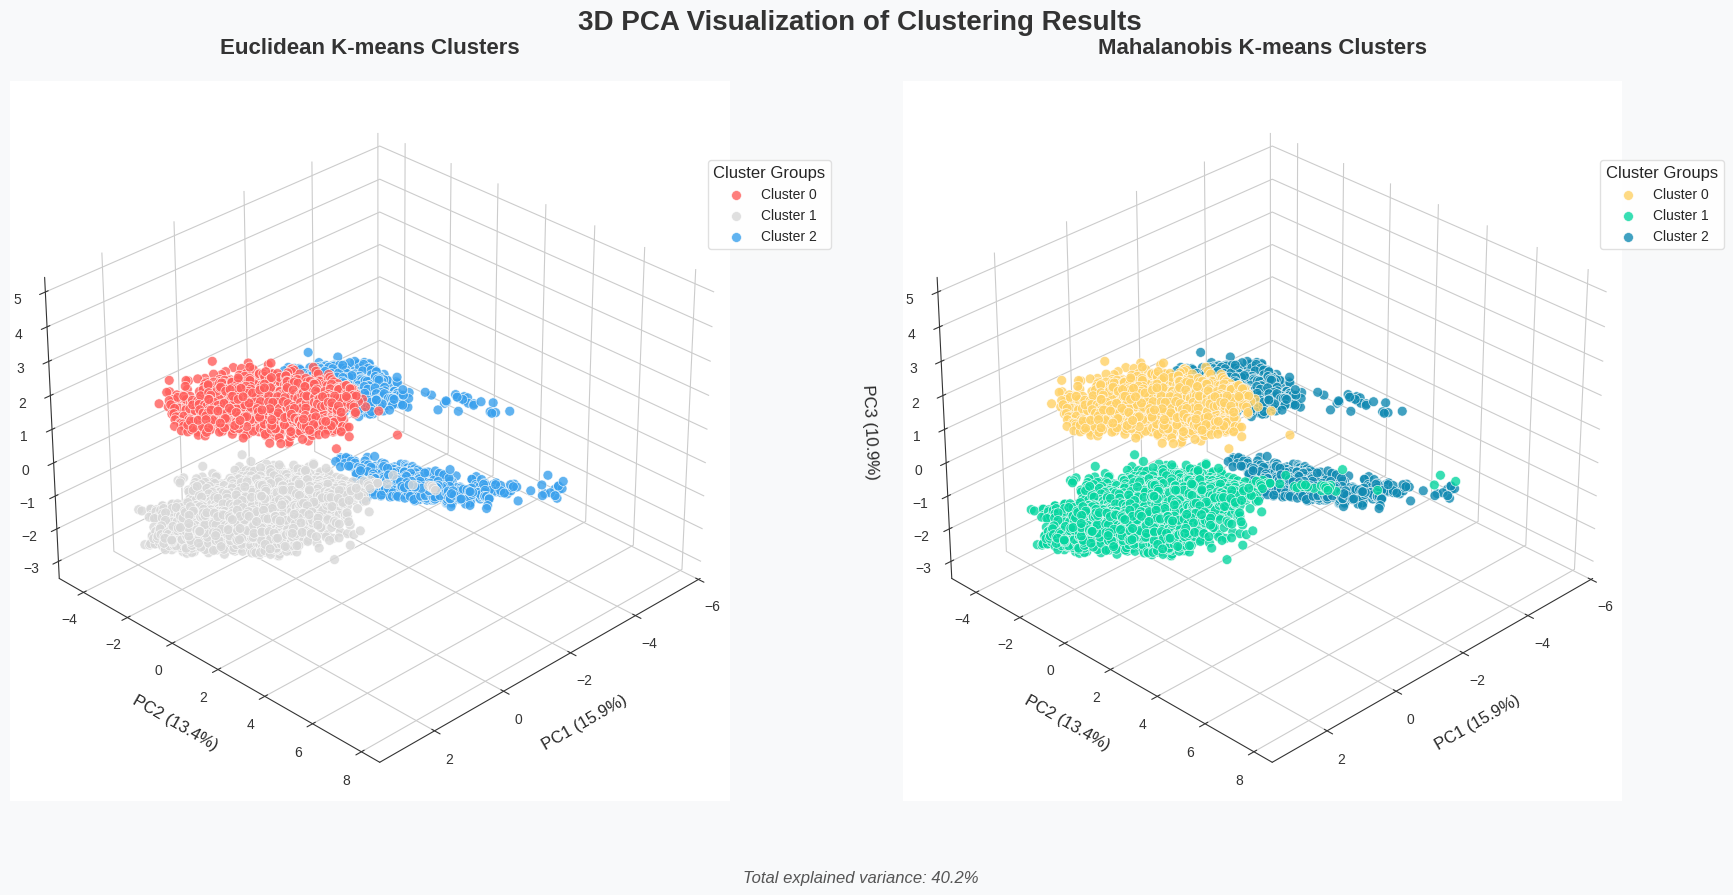

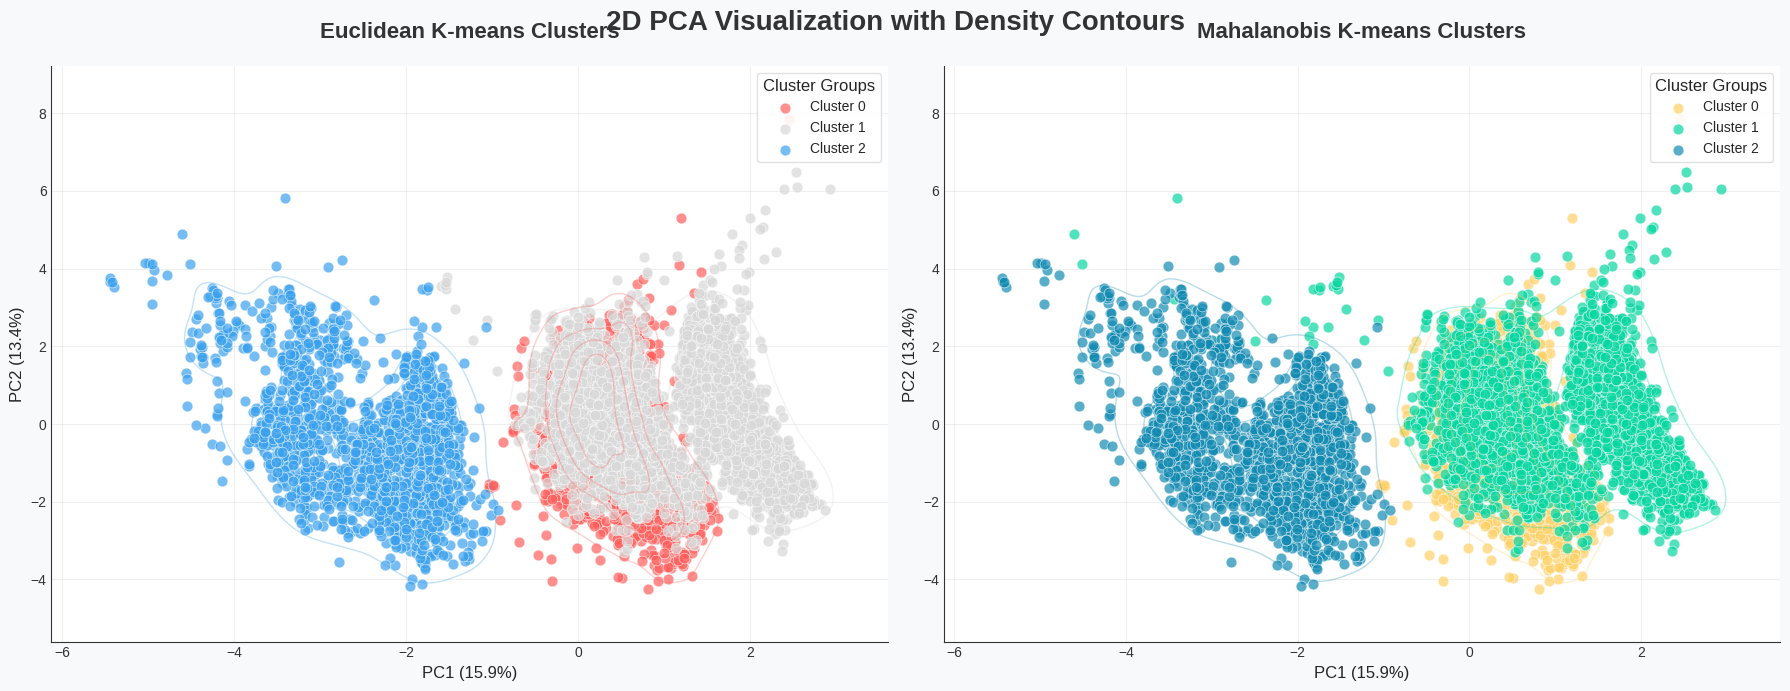

In [40]:
euclidean_palette = ['#FF5E5B', '#D8D8D8', '#39A0ED']  # Coral, Light Gray, Blue
mahalanobis_palette = ['#FFD166', '#06D6A0', '#118AB2']  # Yellow, Teal, Blue


euclidean_palette = ['#FF5E5B', '#D8D8D8', '#39A0ED']  # Coral, Light Gray, Blue
mahalanobis_palette = ['#FFD166', '#06D6A0', '#118AB2']  # Yellow, Teal, Blue


print("Generating enhanced 3D PCA visualization...")
pca = PCA(n_components=3)
X_train_pca = pca.fit_transform(X_train_scaled)


explained_variance = pca.explained_variance_ratio_ * 100


fig = plt.figure(figsize=(18, 9))
fig.patch.set_facecolor('#f8f9fa')  # Light background for the entire figure

# Euclidean clusters - 3D plot
ax1 = fig.add_subplot(121, projection='3d')
for i in range(3):
    cluster_points = X_train_pca[euclidean_clusters == i]
    ax1.scatter(
        cluster_points[:, 0],
        cluster_points[:, 1],
        cluster_points[:, 2],
        s=50,  # Marker size
        c=[euclidean_palette[i]],
        label=f'Cluster {i}',
        alpha=0.8,
        edgecolors='w',
        linewidth=0.5
    )

# Euclidean plot
ax1.set_title('Euclidean K-means Clusters', fontsize=16, pad=20, fontweight='bold', color='#333333')
ax1.set_xlabel(f'PC1 ({explained_variance[0]:.1f}%)', fontsize=12, labelpad=10)
ax1.set_ylabel(f'PC2 ({explained_variance[1]:.1f}%)', fontsize=12, labelpad=10)
ax1.set_zlabel(f'PC3 ({explained_variance[2]:.1f}%)', fontsize=12, labelpad=10)
ax1.grid(True, alpha=0.3)
ax1.xaxis.pane.fill = False
ax1.yaxis.pane.fill = False
ax1.zaxis.pane.fill = False
ax1.xaxis.pane.set_edgecolor('w')
ax1.yaxis.pane.set_edgecolor('w')
ax1.zaxis.pane.set_edgecolor('w')
ax1.view_init(elev=30, azim=45)  # Set viewing angle

# Mahalanobis clusters - 3D plot
ax2 = fig.add_subplot(122, projection='3d')
for i in range(3):
    cluster_points = X_train_pca[mahalanobis_clusters == i]
    ax2.scatter(
        cluster_points[:, 0],
        cluster_points[:, 1],
        cluster_points[:, 2],
        s=50,  # Marker size
        c=[mahalanobis_palette[i]],
        label=f'Cluster {i}',
        alpha=0.8,
        edgecolors='w',
        linewidth=0.5
    )

# Mahalanobis plot
ax2.set_title('Mahalanobis K-means Clusters', fontsize=16, pad=20, fontweight='bold', color='#333333')
ax2.set_xlabel(f'PC1 ({explained_variance[0]:.1f}%)', fontsize=12, labelpad=10)
ax2.set_ylabel(f'PC2 ({explained_variance[1]:.1f}%)', fontsize=12, labelpad=10)
ax2.set_zlabel(f'PC3 ({explained_variance[2]:.1f}%)', fontsize=12, labelpad=10)
ax2.grid(True, alpha=0.3)
ax2.xaxis.pane.fill = False
ax2.yaxis.pane.fill = False
ax2.zaxis.pane.fill = False
ax2.xaxis.pane.set_edgecolor('w')
ax2.yaxis.pane.set_edgecolor('w')
ax2.zaxis.pane.set_edgecolor('w')
ax2.view_init(elev=30, azim=45)  # Set viewing angle

# Add legends with custom styling
for ax in [ax1, ax2]:
    legend = ax.legend(
        title="Cluster Groups",
        title_fontsize=12,
        fontsize=10,
        loc='upper right',
        bbox_to_anchor=(1.15, 0.9),
        frameon=True,
        facecolor='white',
        edgecolor='#dddddd'
    )
    legend.get_frame().set_alpha(0.9)

# title
plt.suptitle('3D PCA Visualization of Clustering Results',
             fontsize=20,
             y=0.98,
             fontweight='bold',
             color='#333333')

# explanatory text
fig.text(0.5, 0.01,
         f'Total explained variance: {sum(explained_variance[:3]):.1f}%',
         ha='center',
         fontsize=12,
         color='#555555',
         style='italic')

# layout and save
plt.tight_layout()
plt.subplots_adjust(top=0.9, bottom=0.1)
plt.savefig('3d_clusters_visualization.png', dpi=300, bbox_inches='tight', facecolor='#f8f9fa')
plt.show()

# Create an additional 2D plot with density contours for better pattern visibility
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
fig.patch.set_facecolor('#f8f9fa')

# Function to add contours
def add_density_contour(ax, x, y, color):
    sns.kdeplot(x=x, y=y, ax=ax, levels=5, color=color, alpha=0.3, linewidths=1)

# Euclidean clusters - 2D with contours
for i in range(3):
    cluster_points = X_train_pca[euclidean_clusters == i]
    ax1.scatter(
        cluster_points[:, 0],
        cluster_points[:, 1],
        s=60,
        c=[euclidean_palette[i]],
        label=f'Cluster {i}',
        alpha=0.7,
        edgecolors='w',
        linewidth=0.5
    )
    add_density_contour(ax1, cluster_points[:, 0], cluster_points[:, 1], euclidean_palette[i])

# Mahalanobis clusters - 2D with contours
for i in range(3):
    cluster_points = X_train_pca[mahalanobis_clusters == i]
    ax2.scatter(
        cluster_points[:, 0],
        cluster_points[:, 1],
        s=60,
        c=[mahalanobis_palette[i]],
        label=f'Cluster {i}',
        alpha=0.7,
        edgecolors='w',
        linewidth=0.5
    )
    add_density_contour(ax2, cluster_points[:, 0], cluster_points[:, 1], mahalanobis_palette[i])

# Customize 2D plots
for i, ax in enumerate([ax1, ax2]):
    title = 'Euclidean K-means Clusters' if i == 0 else 'Mahalanobis K-means Clusters'
    ax.set_title(title, fontsize=16, pad=20, fontweight='bold', color='#333333')
    ax.set_xlabel(f'PC1 ({explained_variance[0]:.1f}%)', fontsize=12)
    ax.set_ylabel(f'PC2 ({explained_variance[1]:.1f}%)', fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Add legends with custom styling
    legend = ax.legend(
        title="Cluster Groups",
        title_fontsize=12,
        fontsize=10,
        loc='upper right',
        frameon=True,
        facecolor='white',
        edgecolor='#dddddd'
    )
    legend.get_frame().set_alpha(0.9)

plt.suptitle('2D PCA Visualization with Density Contours',
             fontsize=20,
             y=0.98,
             fontweight='bold',
             color='#333333')

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.savefig('2d_clusters_with_contours.png', dpi=300, bbox_inches='tight', facecolor='#f8f9fa')
plt.show()

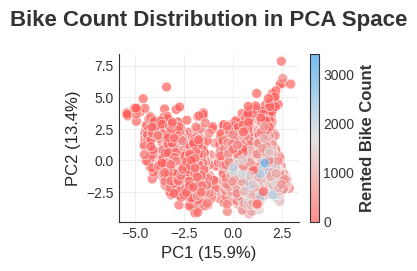

In [41]:
# Visualize target distribution within clusters
plt.subplot(2, 2, 3)
scatter = plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1],
                     c=y_train.values.ravel(),
                     cmap=LinearSegmentedColormap.from_list("custom_cmap", ['#FF5E5B', '#D8D8D8', '#39A0ED']),
                     s=50,
                     alpha=0.7,
                     edgecolors='w',
                     linewidth=0.5)
cbar = plt.colorbar(scatter, label='Rented Bike Count')
cbar.ax.tick_params(labelsize=10)
cbar.set_label('Rented Bike Count', fontsize=12, fontweight='bold', color='#333333')
plt.title('Bike Count Distribution in PCA Space', fontsize=16, pad=20, fontweight='bold', color='#333333')
plt.xlabel(f'PC1 ({explained_variance[0]:.1f}%)', fontsize=12)
plt.ylabel(f'PC2 ({explained_variance[1]:.1f}%)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

In [42]:
print("Model expects features:", len(baseline_model.feature_importances_))
print("feature_names length:", len(feature_names))
print("X_train_filtered columns:", X_train_filtered.shape[1])

# They should all be the same number

Model expects features: 17
feature_names length: 17
X_train_filtered columns: 17


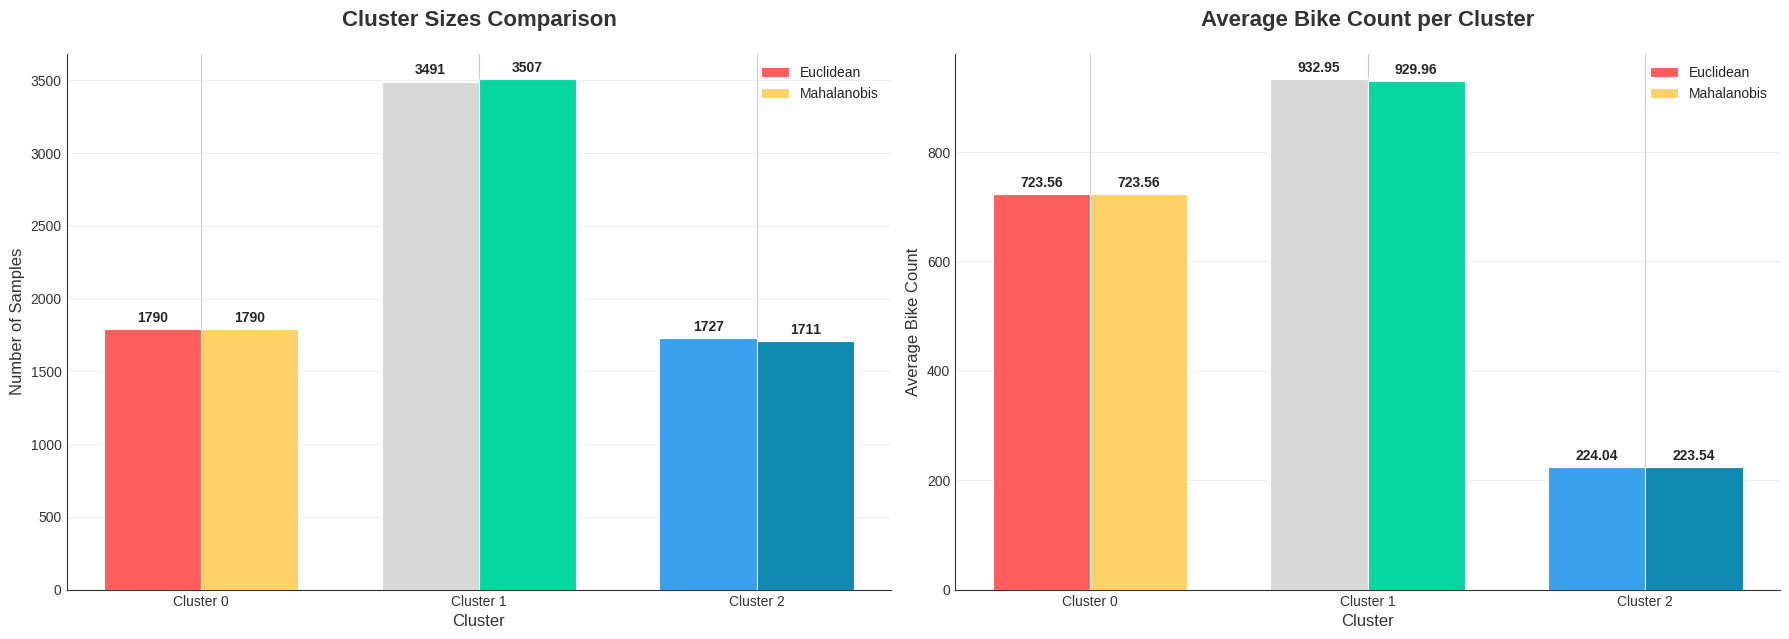

In [43]:
# Visualizing Cluster Analysis
plt.figure(figsize=(18, 12))
fig.patch.set_facecolor('#f8f9fa')


euclidean_palette = ['#FF5E5B', '#D8D8D8', '#39A0ED']  # Coral, Light Gray, Blue

# 1. Cluster Sizes - Top Left
plt.subplot(2, 2, 1)
euclidean_sizes = [sum(euclidean_clusters == i) for i in range(3)]
mahalanobis_sizes = [sum(mahalanobis_clusters == i) for i in range(3)]

x = np.arange(3)  # the label locations
width = 0.35  # the width of the bars

rects1 = plt.bar(x - width/2, euclidean_sizes, width, label='Euclidean',
                color=euclidean_palette, edgecolor='white', linewidth=0.8)
rects2 = plt.bar(x + width/2, mahalanobis_sizes, width, label='Mahalanobis',
                color=['#FFD166', '#06D6A0', '#118AB2'], edgecolor='white', linewidth=0.8)

# Add labels and customize
plt.xlabel('Cluster', fontsize=12, color='#333333')
plt.ylabel('Number of Samples', fontsize=12, color='#333333')
plt.title('Cluster Sizes Comparison', fontsize=16, pad=20, fontweight='bold', color='#333333')
plt.xticks(x, ['Cluster 0', 'Cluster 1', 'Cluster 2'])
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Add count labels on top of bars
for rect in rects1:
    height = rect.get_height()
    plt.annotate(f'{height}',
                xy=(rect.get_x() + rect.get_width()/2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom', fontweight='bold')

for rect in rects2:
    height = rect.get_height()
    plt.annotate(f'{height}',
                xy=(rect.get_x() + rect.get_width()/2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom', fontweight='bold')

# 2. Average Bike Count per Cluster - Top Right
plt.subplot(2, 2, 2)
euclidean_avg_counts = []
mahalanobis_avg_counts = []

for i in range(3):
    # Euclidean
    cluster_indices = euclidean_clusters == i
    if sum(cluster_indices) > 0:
        avg_count = y_train.iloc[cluster_indices].values.mean()
        euclidean_avg_counts.append(avg_count)
    else:
        euclidean_avg_counts.append(0)

    # Mahalanobis
    cluster_indices = mahalanobis_clusters == i
    if sum(cluster_indices) > 0:
        avg_count = y_train.iloc[cluster_indices].values.mean()
        mahalanobis_avg_counts.append(avg_count)
    else:
        mahalanobis_avg_counts.append(0)

rects1 = plt.bar(x - width/2, euclidean_avg_counts, width, label='Euclidean',
                color=euclidean_palette, edgecolor='white', linewidth=0.8)
rects2 = plt.bar(x + width/2, mahalanobis_avg_counts, width, label='Mahalanobis',
                color=['#FFD166', '#06D6A0', '#118AB2'], edgecolor='white', linewidth=0.8)

# Add labels and customize
plt.xlabel('Cluster', fontsize=12, color='#333333')
plt.ylabel('Average Bike Count', fontsize=12, color='#333333')
plt.title('Average Bike Count per Cluster', fontsize=16, pad=20, fontweight='bold', color='#333333')
plt.xticks(x, ['Cluster 0', 'Cluster 1', 'Cluster 2'])
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Add count labels on top of bars
for rect in rects1:
    height = rect.get_height()
    plt.annotate(f'{height:.2f}',
                xy=(rect.get_x() + rect.get_width()/2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom', fontweight='bold')

for rect in rects2:
    height = rect.get_height()
    plt.annotate(f'{height:.2f}',
                xy=(rect.get_x() + rect.get_width()/2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom', fontweight='bold')



plt.tight_layout()
plt.savefig('cluster_analysis_visualization.png', dpi=300, bbox_inches='tight', facecolor='#f8f9fa')
plt.show()

In [44]:
# Additional analysis: Cluster sizes and characteristics
print("\n=== CLUSTER ANALYSIS ===")
print("\nEuclidean Cluster Sizes:")
for i in range(3):
    print(f"Cluster {i}: {sum(euclidean_clusters == i)} samples")

print("\nMahalanobis Cluster Sizes:")
for i in range(3):
    print(f"Cluster {i}: {sum(mahalanobis_clusters == i)} samples")

# Average bike count per cluster
print("\nAverage Bike Count per Cluster:")
print("\nEuclidean Clusters:")
for i in range(3):
    cluster_indices = euclidean_clusters == i
    if sum(cluster_indices) > 0:
        avg_count = y_train.iloc[cluster_indices].values.mean()
        print(f"Cluster {i}: {avg_count:.2f}")

print("\nMahalanobis Clusters:")
for i in range(3):
    cluster_indices = mahalanobis_clusters == i
    if sum(cluster_indices) > 0:
        avg_count = y_train.iloc[cluster_indices].values.mean()
        print(f"Cluster {i}: {avg_count:.2f}")

# Analyze cluster characteristics
print("\nCluster Characteristics (Average Feature Values):")
print("\nEuclidean Clusters:")
for i in range(3):
    cluster_indices = euclidean_clusters == i
    if sum(cluster_indices) > 0:
        cluster_data = X_train.iloc[cluster_indices]
        # Get top 5 most distinctive features (largest difference from overall mean)
        feature_means = cluster_data.mean()
        overall_means = X_train.mean()
        feature_diff = abs(feature_means - overall_means)
        top_features = feature_diff.nlargest(5).index

        print(f"\nCluster {i} distinctive features:")
        for feature in top_features:
            print(f"{feature}: {feature_means[feature]:.2f} (overall: {overall_means[feature]:.2f})")


=== CLUSTER ANALYSIS ===

Euclidean Cluster Sizes:
Cluster 0: 1790 samples
Cluster 1: 3491 samples
Cluster 2: 1727 samples

Mahalanobis Cluster Sizes:
Cluster 0: 1790 samples
Cluster 1: 3507 samples
Cluster 2: 1711 samples

Average Bike Count per Cluster:

Euclidean Clusters:
Cluster 0: 723.56
Cluster 1: 932.95
Cluster 2: 224.04

Mahalanobis Clusters:
Cluster 0: 723.56
Cluster 1: 929.96
Cluster 2: 223.54

Cluster Characteristics (Average Feature Values):

Euclidean Clusters:

Cluster 0 distinctive features:
Visibility: 1237.98 (overall: 1436.83)
Month: 4.00 (overall: 6.52)
Seasons_Spring: 1.00 (overall: 0.26)
Humidity: 58.91 (overall: 58.20)
Seasons_Summer: 0.00 (overall: 0.25)

Cluster 1 distinctive features:
Visibility: 1541.14 (overall: 1436.83)
Dew point temperature: 12.14 (overall: 4.11)
Temperature: 20.47 (overall: 12.93)
Humidity: 61.74 (overall: 58.20)
Month: 8.49 (overall: 6.52)

Cluster 2 distinctive features:
Dew point temperature: -12.21 (overall: 4.11)
Temperature: -2.43 

# **Best Model Evaluation and Comparison**

In [45]:
def plot_r2_comparison(selected_models=None, figsize=(12, 8)):
    """
    Plot R² comparison for all selected models
    """

    # Get results from the tracking dictionary
    results_df = display_simplified_results_table()

    if results_df is None or len(results_df) == 0:
        print("No results available to plot.")
        return

    # Define key models to compare if not specified
    if selected_models is None:
        selected_models = [
            'XGBoost Baseline',
            'XGBoost Optimal (Grid Search)',
            'Cluster-Specific Euclidean',
            'Cluster-Specific Mahalanobis',
            'Random Forest',
            'Neural Network',
            'XGBoost Seasonal (Weighted Average)'
        ]

    # Filter results for selected models
    filtered_df = results_df[results_df['Model'].isin(selected_models)].copy()

    if len(filtered_df) == 0:
        print(f"None of the selected models found in results: {selected_models}")
        print(f"Available models: {results_df['Model'].tolist()}")
        return

    # Define colors - professional palette
    colors = ['#39A0ED', '#FF5E5B', '#118AB2', '#28A745', '#FFD23F']  # Blue, Coral, Dark Blue, Green, Yellow

    # Create shorter display names for better visualization
    display_names_map = {
        'XGBoost Baseline': 'XGB\nBaseline',
        'XGBoost Optimal (Grid Search)': 'XGB\nOptimal',
        'Cluster-Specific Euclidean': 'Euclidean\nClustering',
        'Cluster-Specific Mahalanobis': 'Mahalanobis\nClustering',
        'Random Forest': 'Random\nForest',
        'Neural Network': 'Neural\nNetwork',
        'XGBoost Seasonal (Weighted Average)': 'XGB\nSeasonal'
    }

    # Prepare data for plotting
    models = filtered_df['Model'].tolist()
    display_names = [display_names_map.get(model, model) for model in models]
    r2_values = filtered_df['R²_Test'].tolist()

    # Ensure we have enough colors
    if len(models) > len(colors):
        colors = colors * ((len(models) // len(colors)) + 1)
    colors = colors[:len(models)]

    # Create the figure
    plt.figure(figsize=figsize)

    # R² comparison (higher is better)
    bars = plt.bar(display_names, r2_values, color=colors,
                   edgecolor='white', linewidth=0.8, width=0.7)

    # Add values on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + (max(r2_values) - min(r2_values)) * 0.01,
                f'{height:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=11)

    plt.title('Test R² Comparison\n(higher is better)', fontsize=16, pad=20,
              fontweight='bold', color='#333333')
    plt.ylabel('R²', fontsize=14, color='#333333')
    plt.grid(axis='y', alpha=0.3)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

    # Add reference line for best performance
    max_r2 = max(r2_values)
    plt.axhline(y=max_r2, color='#333333', linestyle='--', alpha=0.5)
    plt.text(len(display_names)-0.5, max_r2 - (max_r2 - min(r2_values)) * 0.05,
             f'Best: {max_r2:.3f}', ha='right', va='top', color='#333333',
             alpha=0.8, fontsize=10)

    plt.tight_layout()
    plt.savefig('r2_comparison.png', dpi=300, bbox_inches='tight', facecolor='#f8f9fa')
    plt.show()

    return filtered_df

def plot_rmse_comparison(selected_models=None, figsize=(12, 8)):
    """
    Plot RMSE comparison for all selected models
    """

    # Get results from the tracking dictionary
    results_df = display_simplified_results_table()

    if results_df is None or len(results_df) == 0:
        print("No results available to plot.")
        return

    # Define key models to compare if not specified
    if selected_models is None:
        selected_models = [
            'XGBoost Baseline',
            'XGBoost Optimal (Grid Search)',
            'Cluster-Specific Euclidean',
            'Cluster-Specific Mahalanobis',
            'Random Forest',
            'Neural Network',
            'XGBoost Seasonal (Weighted Average)'
        ]

    # Filter results for selected models
    filtered_df = results_df[results_df['Model'].isin(selected_models)].copy()

    if len(filtered_df) == 0:
        print(f"None of the selected models found in results: {selected_models}")
        print(f"Available models: {results_df['Model'].tolist()}")
        return

    # Define colors - professional palette
    colors = ['#39A0ED', '#FF5E5B', '#118AB2', '#28A745', '#FFD23F']  # Blue, Coral, Dark Blue, Green, Yellow

    # Create shorter display names for better visualization
    display_names_map = {
        'XGBoost Baseline': 'XGB\nBaseline',
        'XGBoost Optimal (Grid Search)': 'XGB\nOptimal',
        'Cluster-Specific Euclidean': 'Euclidean\nClustering',
        'Cluster-Specific Mahalanobis': 'Mahalanobis\nClustering',
        'Random Forest': 'Random\nForest',
        'Neural Network': 'Neural\nNetwork',
        'XGBoost Seasonal (Weighted Average)': 'XGB\nSeasonal'
    }

    # Prepare data for plotting
    models = filtered_df['Model'].tolist()
    display_names = [display_names_map.get(model, model) for model in models]
    rmse_values = filtered_df['RMSE_Test'].tolist()

    # Ensure we have enough colors
    if len(models) > len(colors):
        colors = colors * ((len(models) // len(colors)) + 1)
    colors = colors[:len(models)]

    # Create the figure
    plt.figure(figsize=figsize)

    # RMSE comparison (lower is better)
    bars = plt.bar(display_names, rmse_values, color=colors,
                   edgecolor='white', linewidth=0.8, width=0.7)

    # Add values on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + max(rmse_values) * 0.01,
                f'{height:.1f}', ha='center', va='bottom', fontweight='bold', fontsize=11)

    plt.title('Test RMSE Comparison\n(lower is better)', fontsize=16, pad=20,
              fontweight='bold', color='#333333')
    plt.ylabel('RMSE', fontsize=14, color='#333333')
    plt.grid(axis='y', alpha=0.3)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

    # Add reference line for best performance
    min_rmse = min(rmse_values)
    plt.axhline(y=min_rmse, color='#333333', linestyle='--', alpha=0.5)
    plt.text(len(display_names)-0.5, min_rmse + (max(rmse_values) - min_rmse) * 0.05,
             f'Best: {min_rmse:.1f}', ha='right', va='bottom', color='#333333',
             alpha=0.8, fontsize=10)

    plt.tight_layout()
    plt.savefig('rmse_comparison.png', dpi=300, bbox_inches='tight', facecolor='#f8f9fa')
    plt.show()

    return filtered_df

def plot_mae_comparison(selected_models=None, figsize=(12, 8)):
    """
    Plot MAE comparison for all selected models
    """

    # Get results from the tracking dictionary
    results_df = display_simplified_results_table()

    if results_df is None or len(results_df) == 0:
        print("No results available to plot.")
        return

    # Define key models to compare if not specified
    if selected_models is None:
        selected_models = [
            'XGBoost Baseline',
            'XGBoost Optimal (Grid Search)',
            'Cluster-Specific Euclidean',
            'Cluster-Specific Mahalanobis',
            'Random Forest',
            'Neural Network',
            'XGBoost Seasonal (Weighted Average)'
        ]

    # Filter results for selected models
    filtered_df = results_df[results_df['Model'].isin(selected_models)].copy()

    if len(filtered_df) == 0:
        print(f"None of the selected models found in results: {selected_models}")
        print(f"Available models: {results_df['Model'].tolist()}")
        return

    # Define colors - professional palette
    colors = ['#39A0ED', '#FF5E5B', '#118AB2', '#28A745', '#FFD23F']  # Blue, Coral, Dark Blue, Green, Yellow

    # Create shorter display names for better visualization
    display_names_map = {
        'XGBoost Baseline': 'XGB\nBaseline',
        'XGBoost Optimal (Grid Search)': 'XGB\nOptimal',
        'Cluster-Specific Euclidean': 'Euclidean\nClustering',
        'Cluster-Specific Mahalanobis': 'Mahalanobis\nClustering',
        'Random Forest': 'Random\nForest',
        'Neural Network': 'Neural\nNetwork',
        'XGBoost Seasonal (Weighted Average)': 'XGB\nSeasonal'
    }

    # Prepare data for plotting
    models = filtered_df['Model'].tolist()
    display_names = [display_names_map.get(model, model) for model in models]
    mae_values = filtered_df['MAE_Test'].tolist()

    # Ensure we have enough colors
    if len(models) > len(colors):
        colors = colors * ((len(models) // len(colors)) + 1)
    colors = colors[:len(models)]

    # Create the figure
    plt.figure(figsize=figsize)

    # MAE comparison (lower is better)
    bars = plt.bar(display_names, mae_values, color=colors,
                   edgecolor='white', linewidth=0.8, width=0.7)

    # Add values on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + max(mae_values) * 0.01,
                f'{height:.1f}', ha='center', va='bottom', fontweight='bold', fontsize=11)

    plt.title('Test MAE Comparison\n(lower is better)', fontsize=16, pad=20,
              fontweight='bold', color='#333333')
    plt.ylabel('MAE', fontsize=14, color='#333333')
    plt.grid(axis='y', alpha=0.3)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

    # Add reference line for best performance
    min_mae = min(mae_values)
    plt.axhline(y=min_mae, color='#333333', linestyle='--', alpha=0.5)
    plt.text(len(display_names)-0.5, min_mae + (max(mae_values) - min_mae) * 0.05,
             f'Best: {min_mae:.1f}', ha='right', va='bottom', color='#333333',
             alpha=0.8, fontsize=10)

    plt.tight_layout()
    plt.savefig('mae_comparison.png', dpi=300, bbox_inches='tight', facecolor='#f8f9fa')
    plt.show()

    return filtered_df

def plot_all_metrics_combined(selected_models=None, figsize=(15, 6)):
    """
    Plot all three metrics side by side for comparison
    """

    # Get results from the tracking dictionary
    results_df = display_results_table()

    if results_df is None or len(results_df) == 0:
        print("No results available to plot.")
        return

    # Define key models to compare if not specified
    if selected_models is None:
        selected_models = [
            'XGBoost Baseline',
            'XGBoost Optimal (Grid Search)',
            'Cluster-Specific Euclidean',
            'Cluster-Specific Mahalanobis',
            'Random Forest',
            'Neural Network',
            'XGBoost Seasonal (Weighted Average)'
        ]

    # Filter results for selected models
    filtered_df = results_df[results_df['Model'].isin(selected_models)].copy()

    if len(filtered_df) == 0:
        print(f"None of the selected models found in results: {selected_models}")
        print(f"Available models: {results_df['Model'].tolist()}")
        return

    # Define colors - professional palette
    colors = ['#39A0ED', '#FF5E5B', '#118AB2', '#28A745', '#FFD23F']  # Blue, Coral, Dark Blue, Green, Yellow

    # Create shorter display names for better visualization
    display_names_map = {
        'XGBoost Baseline': 'XGB\nBaseline',
        'XGBoost Optimal (Grid Search)': 'XGB\nOptimal',
        'Cluster-Specific Euclidean': 'Euclidean\nClustering',
        'Cluster-Specific Mahalanobis': 'Mahalanobis\nClustering',
        'Random Forest': 'Random\nForest',
        'Neural Network': 'Neural\nNetwork',
        'XGBoost Seasonal (Weighted Average)': 'XGB\nSeasonal'
    }

    # Prepare data for plotting
    models = filtered_df['Model'].tolist()
    display_names = [display_names_map.get(model, model) for model in models]
    rmse_values = filtered_df['RMSE_Test'].tolist()
    r2_values = filtered_df['R²_Test'].tolist()
    mae_values = filtered_df['MAE_Test'].tolist()

    # Ensure we have enough colors
    if len(models) > len(colors):
        colors = colors * ((len(models) // len(colors)) + 1)
    colors = colors[:len(models)]

    # Create the figure
    plt.figure(figsize=figsize)

    # RMSE comparison (lower is better)
    plt.subplot(1, 3, 1)
    bars = plt.bar(display_names, rmse_values, color=colors,
                   edgecolor='white', linewidth=0.8, width=0.7)

    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + max(rmse_values) * 0.01,
                f'{height:.1f}', ha='center', va='bottom', fontweight='bold', fontsize=10)

    plt.title('Test RMSE Comparison\n(lower is better)', fontsize=14, pad=15,
              fontweight='bold', color='#333333')
    plt.ylabel('RMSE', fontsize=12, color='#333333')
    plt.grid(axis='y', alpha=0.3)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

    min_rmse = min(rmse_values)
    plt.axhline(y=min_rmse, color='#333333', linestyle='--', alpha=0.5)

    # R² comparison (higher is better)
    plt.subplot(1, 3, 2)
    bars = plt.bar(display_names, r2_values, color=colors,
                   edgecolor='white', linewidth=0.8, width=0.7)

    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + (max(r2_values) - min(r2_values)) * 0.01,
                f'{height:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=10)

    plt.title('Test R² Comparison\n(higher is better)', fontsize=14, pad=15,
              fontweight='bold', color='#333333')
    plt.ylabel('R²', fontsize=12, color='#333333')
    plt.grid(axis='y', alpha=0.3)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

    max_r2 = max(r2_values)
    plt.axhline(y=max_r2, color='#333333', linestyle='--', alpha=0.5)

    # MAE comparison (lower is better)
    plt.subplot(1, 3, 3)
    bars = plt.bar(display_names, mae_values, color=colors,
                   edgecolor='white', linewidth=0.8, width=0.7)

    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + max(mae_values) * 0.01,
                f'{height:.1f}', ha='center', va='bottom', fontweight='bold', fontsize=10)

    plt.title('Test MAE Comparison\n(lower is better)', fontsize=14, pad=15,
              fontweight='bold', color='#333333')
    plt.ylabel('MAE', fontsize=12, color='#333333')
    plt.grid(axis='y', alpha=0.3)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

    min_mae = min(mae_values)
    plt.axhline(y=min_mae, color='#333333', linestyle='--', alpha=0.5)

    plt.suptitle('Bike Sharing Demand Prediction: Model Performance Comparison',
                 fontsize=16, y=1.02, fontweight='bold', color='#333333')

    plt.tight_layout()
    plt.subplots_adjust(top=0.88)
    plt.savefig('all_metrics_comparison.png', dpi=300, bbox_inches='tight', facecolor='#f8f9fa')
    plt.show()

    return filtered_df

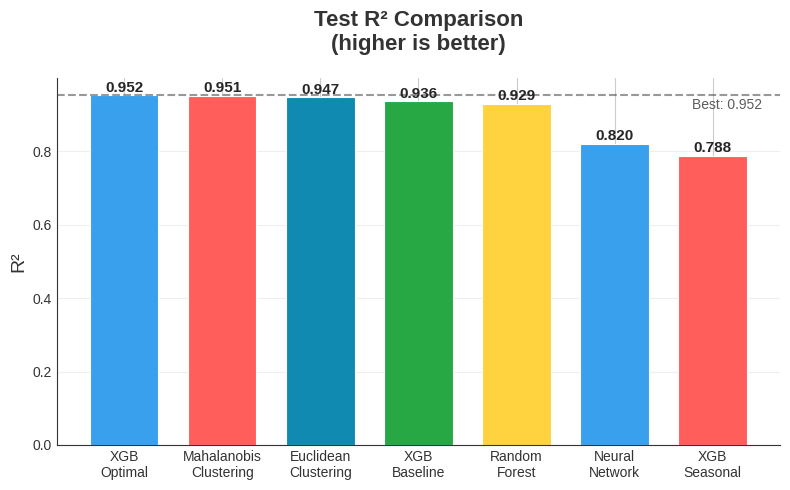

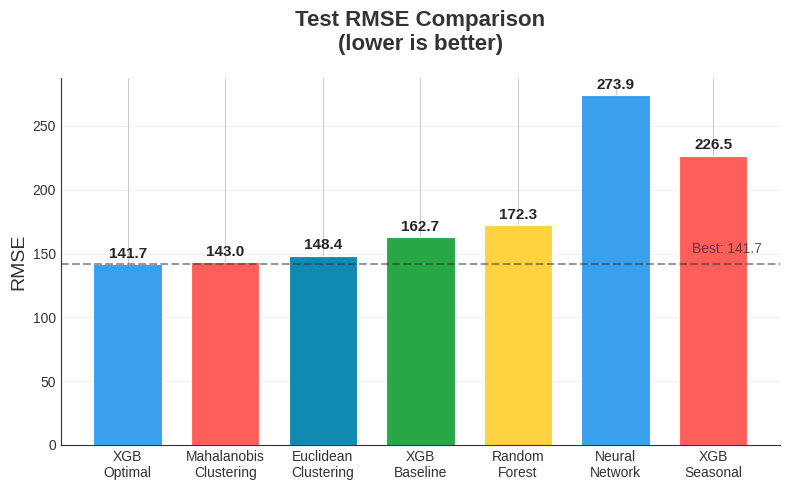

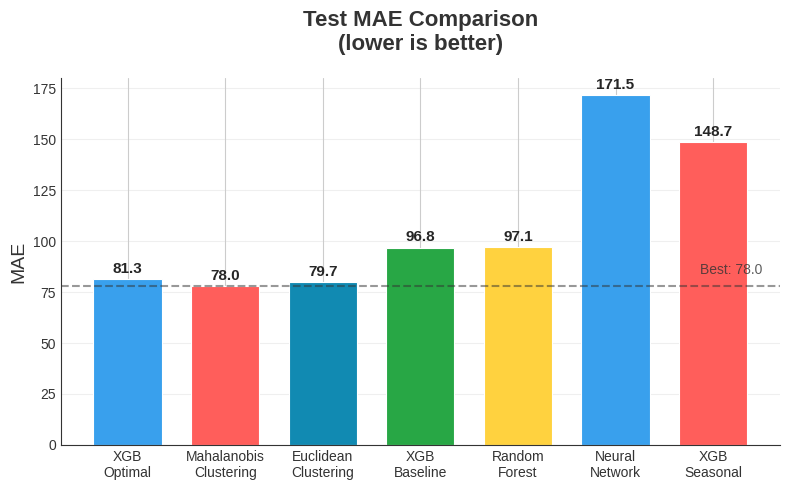

,Model,R²_Test,RMSE_Test,MAE_Test,Notes
0,XGBoost Optimal (Grid Search),0.9518,141.66,81.32,Grid search optimized
1,Cluster-Specific Mahalanobis,0.9509,143.00,77.96,Mahalanobis clustering + XGBoost
2,Cluster-Specific Euclidean,0.9471,148.42,79.74,Euclidean clustering + XGBoost
3,XGBoost Baseline,0.9364,162.74,96.82,"Default XGBoost parameters, VIF removal"
4,Random Forest,0.9287,172.32,97.09,"Simple Random Forest, default parameters"
7,Neural Network,0.8199,273.91,171.52,Neural network with 3 hidden layers and dropout
8,XGBoost Seasonal (Weighted Average),0.7876,226.53,148.65,"Weighted avg of 4 seasonal models, CV R²: 0.7971"


In [46]:
# Bar charts for R^2, RMSE, and MAE
plot_r2_comparison(figsize=(8, 5))
plot_rmse_comparison(figsize=(8, 5))
plot_mae_comparison(figsize=(8, 5))

In [47]:
def plot_all_metrics_combined(selected_models=None, figsize=(15, 5)):
    """
    Plot all three metrics side by side for comparison - FIXED VERSION
    """

    results_df = display_results_table()  # Use full results table

    if results_df is None or len(results_df) == 0:
        print("No results available to plot.")
        return

    if selected_models is None:
        selected_models = [
            'XGBoost Baseline',
            'XGBoost Optimal (Grid Search)',
            'Cluster-Specific Euclidean',
            'Cluster-Specific Mahalanobis',
            'Random Forest',
            'Neural Network',
            'XGBoost Seasonal (Weighted Average)'
        ]

    # Filter results for selected models
    filtered_df = results_df[results_df['Model'].isin(selected_models)].copy()

    if len(filtered_df) == 0:
        print(f"None of the selected models found in results: {selected_models}")
        print(f"Available models: {results_df['Model'].tolist()}")
        return

    # 🔧 FIX 3: Extended color palette for more models
    colors = ['#39A0ED', '#FF5E5B', '#118AB2', '#06D6A0', '#FFD166', '#28A745', '#FFD23F']

    # 🔧 FIX 4: Complete display names map
    display_names_map = {
        'XGBoost Baseline': 'XGB\nBaseline',
        'XGBoost Optimal (Grid Search)': 'XGB\nOptimal',
        'Cluster-Specific Euclidean': 'Euclidean\nClustering',
        'Cluster-Specific Mahalanobis': 'Mahalanobis\nClustering',
        'Random Forest': 'Random\nForest',
        'Neural Network': 'Neural\nNetwork',
        'XGBoost Seasonal (Weighted Average)': 'XGB\nSeasonal'
    }

    # Prepare data for plotting
    models = filtered_df['Model'].tolist()
    display_names = [display_names_map.get(model, model.replace(' ', '\n')) for model in models]
    rmse_values = filtered_df['RMSE_Test'].tolist()
    r2_values = filtered_df['R²_Test'].tolist()
    mae_values = filtered_df['MAE_Test'].tolist()

    # Ensure we have enough colors
    colors = colors[:len(models)]

    # Create the figure
    plt.figure(figsize=figsize)

    # RMSE comparison (lower is better)
    plt.subplot(1, 3, 1)
    bars = plt.bar(display_names, rmse_values, color=colors,
                   edgecolor='white', linewidth=0.8, width=0.7)

    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + max(rmse_values) * 0.01,
                f'{height:.1f}', ha='center', va='bottom', fontweight='bold', fontsize=9)

    plt.title('Test RMSE Comparison\n(lower is better)', fontsize=14, pad=15,
              fontweight='bold', color='#333333')
    plt.ylabel('RMSE', fontsize=12, color='#333333')
    plt.grid(axis='y', alpha=0.3)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.xticks(rotation=45, ha='right')  # Rotate labels for better fit

    min_rmse = min(rmse_values)
    plt.axhline(y=min_rmse, color='#333333', linestyle='--', alpha=0.5)

    # R² comparison (higher is better)
    plt.subplot(1, 3, 2)
    bars = plt.bar(display_names, r2_values, color=colors,
                   edgecolor='white', linewidth=0.8, width=0.7)

    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + (max(r2_values) - min(r2_values)) * 0.01,
                f'{height:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=9)

    plt.title('Test R² Comparison\n(higher is better)', fontsize=14, pad=15,
              fontweight='bold', color='#333333')
    plt.ylabel('R²', fontsize=12, color='#333333')
    plt.grid(axis='y', alpha=0.3)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.xticks(rotation=45, ha='right')

    max_r2 = max(r2_values)
    plt.axhline(y=max_r2, color='#333333', linestyle='--', alpha=0.5)

    # MAE comparison (lower is better)
    plt.subplot(1, 3, 3)
    bars = plt.bar(display_names, mae_values, color=colors,
                   edgecolor='white', linewidth=0.8, width=0.7)

    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + max(mae_values) * 0.01,
                f'{height:.1f}', ha='center', va='bottom', fontweight='bold', fontsize=9)

    plt.title('Test MAE Comparison\n(lower is better)', fontsize=14, pad=15,
              fontweight='bold', color='#333333')
    plt.ylabel('MAE', fontsize=12, color='#333333')
    plt.grid(axis='y', alpha=0.3)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.xticks(rotation=45, ha='right')

    min_mae = min(mae_values)
    plt.axhline(y=min_mae, color='#333333', linestyle='--', alpha=0.5)

    plt.suptitle('Bike Sharing Demand Prediction: Model Performance Comparison',
                 fontsize=16, y=1.02, fontweight='bold', color='#333333')

    plt.tight_layout()
    plt.subplots_adjust(top=0.88, bottom=0.15)  # Extra space for rotated labels
    plt.savefig('all_metrics_comparison.png', dpi=300, bbox_inches='tight', facecolor='#f8f9fa')
    plt.show()

# 🔧 Function to plot ALL models including individual seasons
def plot_all_models_comprehensive(figsize=(24, 8)):
    """
    Plot ALL 11 models including individual seasonal models
    """

    results_df = display_results_table()

    if results_df is None or len(results_df) == 0:
        print("No results available to plot.")
        return

    # Include ALL models from your debug output
    all_models = [
        'XGBoost Baseline',
        'XGBoost Optimal (Grid Search)',
        'Cluster-Specific Euclidean',
        'Cluster-Specific Mahalanobis',
        'Random Forest',
        'Neural Network',
        'Winter',
        'Spring',
        'Summer',
        'Autumn',
        'XGBoost Seasonal (Weighted Average)'
    ]

    # Filter results for all models
    filtered_df = results_df[results_df['Model'].isin(all_models)].copy()

    # Extended color palette for 11 models
    colors = ['#39A0ED', '#FF5E5B', '#118AB2', '#06D6A0', '#FFD166',
              '#28A745', '#FF6B6B', '#4ECDC4', '#95E1D3', '#F3D250', '#A8E6CF']

    # Complete display names map
    display_names_map = {
        'XGBoost Baseline': 'XGB\nBaseline',
        'XGBoost Optimal (Grid Search)': 'XGB\nOptimal',
        'Cluster-Specific Euclidean': 'Euclidean\nClustering',
        'Cluster-Specific Mahalanobis': 'Mahalanobis\nClustering',
        'Random Forest': 'Random\nForest',
        'Neural Network': 'Neural\nNetwork',
        'Winter': 'Winter\nModel',
        'Spring': 'Spring\nModel',
        'Summer': 'Summer\nModel',
        'Autumn': 'Autumn\nModel',
        'XGBoost Seasonal (Weighted Average)': 'Seasonal\nWeighted'
    }

    # Prepare data for plotting
    models = filtered_df['Model'].tolist()
    display_names = [display_names_map.get(model, model.replace(' ', '\n')) for model in models]
    rmse_values = filtered_df['RMSE_Test'].tolist()
    r2_values = filtered_df['R²_Test'].tolist()
    mae_values = filtered_df['MAE_Test'].tolist()

    colors = colors[:len(models)]

    # Create the figure
    plt.figure(figsize=figsize)

    # R² comparison (higher is better) - Main focus
    plt.subplot(1, 3, 2)  # Put R² in center for emphasis
    bars = plt.bar(display_names, r2_values, color=colors,
                   edgecolor='white', linewidth=0.8, width=0.7)

    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + (max(r2_values) - min(r2_values)) * 0.01,
                f'{height:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=8)

    plt.title('Test R² Comparison - ALL MODELS\n(higher is better)', fontsize=14, pad=15,
              fontweight='bold', color='#333333')
    plt.ylabel('R²', fontsize=12, color='#333333')
    plt.grid(axis='y', alpha=0.3)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.xticks(rotation=45, ha='right', fontsize=9)

    max_r2 = max(r2_values)
    plt.axhline(y=max_r2, color='#333333', linestyle='--', alpha=0.5)

    # RMSE comparison (lower is better)
    plt.subplot(1, 3, 1)
    bars = plt.bar(display_names, rmse_values, color=colors,
                   edgecolor='white', linewidth=0.8, width=0.7)

    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + max(rmse_values) * 0.01,
                f'{height:.0f}', ha='center', va='bottom', fontweight='bold', fontsize=8)

    plt.title('Test RMSE Comparison\n(lower is better)', fontsize=14, pad=15,
              fontweight='bold', color='#333333')
    plt.ylabel('RMSE', fontsize=12, color='#333333')
    plt.grid(axis='y', alpha=0.3)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.xticks(rotation=45, ha='right', fontsize=9)

    min_rmse = min(rmse_values)
    plt.axhline(y=min_rmse, color='#333333', linestyle='--', alpha=0.5)

    # MAE comparison (lower is better)
    plt.subplot(1, 3, 3)
    bars = plt.bar(display_names, mae_values, color=colors,
                   edgecolor='white', linewidth=0.8, width=0.7)

    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + max(mae_values) * 0.01,
                f'{height:.0f}', ha='center', va='bottom', fontweight='bold', fontsize=8)

    plt.title('Test MAE Comparison\n(lower is better)', fontsize=14, pad=15,
              fontweight='bold', color='#333333')
    plt.ylabel('MAE', fontsize=12, color='#333333')
    plt.grid(axis='y', alpha=0.3)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.xticks(rotation=45, ha='right', fontsize=9)

    min_mae = min(mae_values)
    plt.axhline(y=min_mae, color='#333333', linestyle='--', alpha=0.5)

    plt.suptitle('Complete Model Performance Comparison: All 11 Models',
                 fontsize=18, y=1.02, fontweight='bold', color='#333333')

    plt.tight_layout()
    plt.subplots_adjust(top=0.85, bottom=0.2)  # Extra space for rotated labels
    plt.savefig('comprehensive_model_comparison.png', dpi=300, bbox_inches='tight', facecolor='#f8f9fa')
    plt.show()

    # Print top 3 performers
    print("🏆 TOP PERFORMERS:")
    print("=" * 40)
    best_r2_idx = r2_values.index(max(r2_values))
    best_rmse_idx = rmse_values.index(min(rmse_values))
    best_mae_idx = mae_values.index(min(mae_values))

    print(f"🥇 Best R²: {models[best_r2_idx]} ({max(r2_values):.3f})")
    print(f"🥇 Best RMSE: {models[best_rmse_idx]} ({min(rmse_values):.1f})")
    print(f"🥇 Best MAE: {models[best_mae_idx]} ({min(mae_values):.1f})")

    return filtered_df

def plot_rmse_comparison(selected_models=None, figsize=(8, 5)):
    """
    RMSE comparison with clustering models included
    """
    results_df = display_results_table()  # Use full table

    if results_df is None or len(results_df) == 0:
        print("No results available to plot.")
        return

    if selected_models is None:
        selected_models = [
            'XGBoost Baseline',
            'XGBoost Optimal (Grid Search)',
            'Cluster-Specific Euclidean',      # ✅ ADDED
            'Cluster-Specific Mahalanobis',   # ✅ ADDED
            'Random Forest',
            'Neural Network',
            'XGBoost Seasonal (Weighted Average)'
        ]

    filtered_df = results_df[results_df['Model'].isin(selected_models)].copy()

    if len(filtered_df) == 0:
        print(f"None of the selected models found in results: {selected_models}")
        print(f"Available models: {results_df['Model'].tolist()}")
        return

    colors = ['#39A0ED', '#FF5E5B', '#118AB2', '#06D6A0', '#FFD166', '#28A745', '#FFD23F']

    display_names_map = {
        'XGBoost Baseline': 'XGB\nBaseline',
        'XGBoost Optimal (Grid Search)': 'XGB\nOptimal',
        'Cluster-Specific Euclidean': 'Euclidean\nClustering',      # ✅ ADDED
        'Cluster-Specific Mahalanobis': 'Mahalanobis\nClustering', # ✅ ADDED
        'Random Forest': 'Random\nForest',
        'Neural Network': 'Neural\nNetwork',
        'XGBoost Seasonal (Weighted Average)': 'XGB\nSeasonal'
    }

    models = filtered_df['Model'].tolist()
    display_names = [display_names_map.get(model, model.replace(' ', '\n')) for model in models]
    rmse_values = filtered_df['RMSE_Test'].tolist()
    colors = colors[:len(models)]

    plt.figure(figsize=figsize)
    bars = plt.bar(display_names, rmse_values, color=colors,
                   edgecolor='white', linewidth=0.8, width=0.7)

    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + max(rmse_values) * 0.01,
                f'{height:.1f}', ha='center', va='bottom', fontweight='bold', fontsize=11)

    plt.title('Test RMSE Comparison\n(lower is better)', fontsize=16, pad=20,
              fontweight='bold', color='#333333')
    plt.ylabel('RMSE', fontsize=14, color='#333333')
    plt.grid(axis='y', alpha=0.3)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.xticks(rotation=45, ha='right')

    min_rmse = min(rmse_values)
    plt.axhline(y=min_rmse, color='#333333', linestyle='--', alpha=0.5)
    plt.text(len(display_names)-0.5, min_rmse + (max(rmse_values) - min_rmse) * 0.05,
             f'Best: {min_rmse:.1f}', ha='right', va='bottom', color='#333333',
             alpha=0.8, fontsize=10)

    plt.tight_layout()
    plt.subplots_adjust(bottom=0.15)
    plt.savefig('rmse_comparison.png', dpi=300, bbox_inches='tight', facecolor='#f8f9fa')
    plt.show()

    return filtered_df

def plot_mae_comparison(selected_models=None, figsize=(8, 5)):
    """
    MAE comparison with clustering models included
    """
    results_df = display_results_table()  # Use full table

    if results_df is None or len(results_df) == 0:
        print("No results available to plot.")
        return

    if selected_models is None:
        selected_models = [
            'XGBoost Baseline',
            'XGBoost Optimal (Grid Search)',
            'Cluster-Specific Euclidean',      # ✅ ADDED
            'Cluster-Specific Mahalanobis',   # ✅ ADDED
            'Random Forest',
            'Neural Network',
            'XGBoost Seasonal (Weighted Average)'
        ]

    filtered_df = results_df[results_df['Model'].isin(selected_models)].copy()

    if len(filtered_df) == 0:
        print(f"None of the selected models found in results: {selected_models}")
        print(f"Available models: {results_df['Model'].tolist()}")
        return

    colors = ['#39A0ED', '#FF5E5B', '#118AB2', '#06D6A0', '#FFD166', '#28A745', '#FFD23F']

    display_names_map = {
        'XGBoost Baseline': 'XGB\nBaseline',
        'XGBoost Optimal (Grid Search)': 'XGB\nOptimal',
        'Cluster-Specific Euclidean': 'Euclidean\nClustering',      # ✅ ADDED
        'Cluster-Specific Mahalanobis': 'Mahalanobis\nClustering', # ✅ ADDED
        'Random Forest': 'Random\nForest',
        'Neural Network': 'Neural\nNetwork',
        'XGBoost Seasonal (Weighted Average)': 'XGB\nSeasonal'
    }

    models = filtered_df['Model'].tolist()
    display_names = [display_names_map.get(model, model.replace(' ', '\n')) for model in models]
    mae_values = filtered_df['MAE_Test'].tolist()
    colors = colors[:len(models)]

    plt.figure(figsize=figsize)
    bars = plt.bar(display_names, mae_values, color=colors,
                   edgecolor='white', linewidth=0.8, width=0.7)

    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + max(mae_values) * 0.01,
                f'{height:.1f}', ha='center', va='bottom', fontweight='bold', fontsize=11)

    plt.title('Test MAE Comparison\n(lower is better)', fontsize=16, pad=20,
              fontweight='bold', color='#333333')
    plt.ylabel('MAE', fontsize=14, color='#333333')
    plt.grid(axis='y', alpha=0.3)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.xticks(rotation=45, ha='right')

    min_mae = min(mae_values)
    plt.axhline(y=min_mae, color='#333333', linestyle='--', alpha=0.5)
    plt.text(len(display_names)-0.5, min_mae + (max(mae_values) - min_mae) * 0.05,
             f'Best: {min_mae:.1f}', ha='right', va='bottom', color='#333333',
             alpha=0.8, fontsize=10)

    plt.tight_layout()
    plt.subplots_adjust(bottom=0.15)
    plt.savefig('mae_comparison.png', dpi=300, bbox_inches='tight', facecolor='#f8f9fa')
    plt.show()

    return filtered_df

# 🔧 Debug function to check what models are available
def debug_available_models():
    """
    Check what models are actually stored in your results
    """
    print("🔍 DEBUGGING MODEL AVAILABILITY")
    print("=" * 50)

    # Check both data sources
    try:
        results_df = display_results_table()
        print(f"📊 display_results_table() has {len(results_df)} models:")
        for i, model in enumerate(results_df['Model'], 1):
            print(f"   {i}. {model}")
    except Exception as e:
        print(f"❌ Error with display_results_table(): {e}")

    print()

    try:
        simple_df = display_simplified_results_table()
        print(f"📊 display_simplified_results_table() has {len(simple_df)} models:")
        for i, model in enumerate(simple_df['Model'], 1):
            print(f"   {i}. {model}")
    except Exception as e:
        print(f"❌ Error with display_simplified_results_table(): {e}")

    print()

    # Check raw model_results dictionary
    try:
        print(f"📊 Raw model_results has {len(model_results['Model'])} models:")
        for i, model in enumerate(model_results['Model'], 1):
            print(f"   {i}. {model}")
    except Exception as e:
        print(f"❌ Error with model_results: {e}")

# 🔧 Fixed individual plotting functions
def plot_r2_comparison(selected_models=None, figsize=(8, 5)):
    """
    R² comparison with clustering models included
    """
    results_df = display_results_table()  # Use full table

    if results_df is None or len(results_df) == 0:
        print("No results available to plot.")
        return

    if selected_models is None:
        selected_models = [
            'XGBoost Baseline',
            'XGBoost Optimal (Grid Search)',
            'Cluster-Specific Euclidean',      # ✅ ADDED
            'Cluster-Specific Mahalanobis',   # ✅ ADDED
            'Random Forest',
            'Neural Network',
            'XGBoost Seasonal (Weighted Average)'
        ]

    filtered_df = results_df[results_df['Model'].isin(selected_models)].copy()

    if len(filtered_df) == 0:
        print(f"None of the selected models found in results: {selected_models}")
        print(f"Available models: {results_df['Model'].tolist()}")
        return

    colors = ['#39A0ED', '#FF5E5B', '#118AB2', '#06D6A0', '#FFD166', '#28A745', '#FFD23F']

    display_names_map = {
        'XGBoost Baseline': 'XGB\nBaseline',
        'XGBoost Optimal (Grid Search)': 'XGB\nOptimal',
        'Cluster-Specific Euclidean': 'Euclidean\nClustering',      # ✅ ADDED
        'Cluster-Specific Mahalanobis': 'Mahalanobis\nClustering', # ✅ ADDED
        'Random Forest': 'Random\nForest',
        'Neural Network': 'Neural\nNetwork',
        'XGBoost Seasonal (Weighted Average)': 'XGB\nSeasonal'
    }

    models = filtered_df['Model'].tolist()
    display_names = [display_names_map.get(model, model.replace(' ', '\n')) for model in models]
    r2_values = filtered_df['R²_Test'].tolist()
    colors = colors[:len(models)]

    plt.figure(figsize=figsize)
    bars = plt.bar(display_names, r2_values, color=colors,
                   edgecolor='white', linewidth=0.8, width=0.7)

    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + (max(r2_values) - min(r2_values)) * 0.01,
                f'{height:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=11)

    plt.title('Test R² Comparison - ALL MODELS\n(higher is better)', fontsize=16, pad=20,
              fontweight='bold', color='#333333')
    plt.ylabel('R²', fontsize=14, color='#333333')
    plt.grid(axis='y', alpha=0.3)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.xticks(rotation=45, ha='right')

    max_r2 = max(r2_values)
    plt.axhline(y=max_r2, color='#333333', linestyle='--', alpha=0.5)
    plt.text(len(display_names)-0.5, max_r2 - (max_r2 - min(r2_values)) * 0.05,
             f'Best: {max_r2:.3f}', ha='right', va='top', color='#333333',
             alpha=0.8, fontsize=10)

    plt.tight_layout()
    plt.subplots_adjust(bottom=0.15)
    plt.savefig('r2_comparison.png', dpi=300, bbox_inches='tight', facecolor='#f8f9fa')
    plt.show()

    return filtered_df

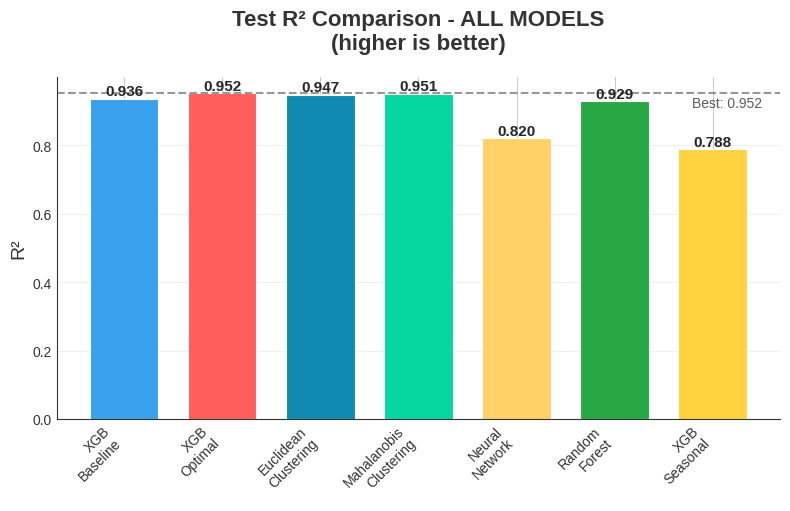

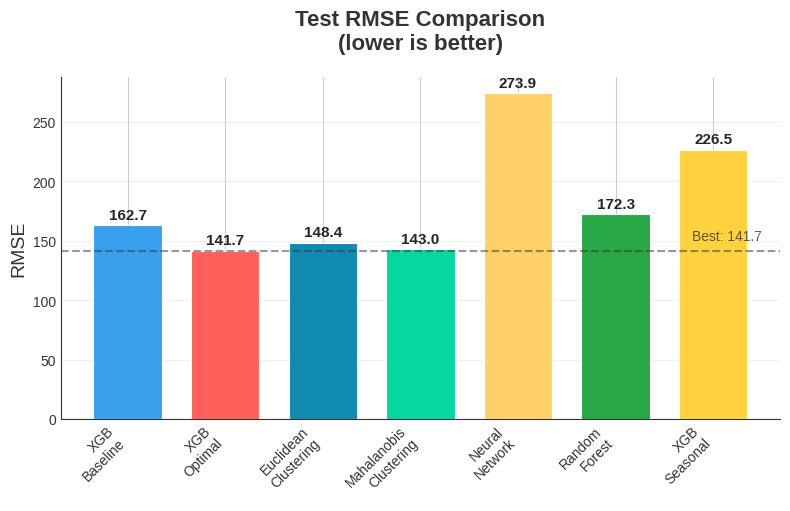

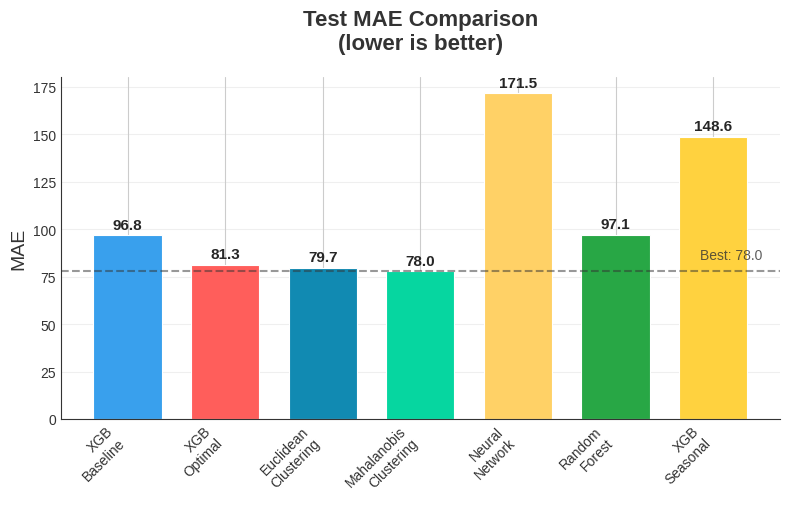

,Model,R²_Train,R²_Test,RMSE_Train,RMSE_Test,MAE_Train,MAE_Test,Notes,Trained_Model
0,XGBoost Baseline,0.9883,0.9364,69.7798,162.7383,45.7172,96.8159,"Default XGBoost parameters, VIF removal","XGBRegressor(base_score=None, booster=None, ca..."
1,XGBoost Optimal (Grid Search),0.9947,0.9518,46.7708,141.6577,30.5316,81.3220,Grid search optimized,"XGBRegressor(base_score=None, booster=None, ca..."
2,Cluster-Specific Euclidean,0.9989,0.9471,21.1500,148.4179,13.6329,79.7423,Euclidean clustering + XGBoost,None
3,Cluster-Specific Mahalanobis,0.9990,0.9509,20.6803,142.9966,13.8583,77.9614,Mahalanobis clustering + XGBoost,None
4,Neural Network,0.8543,0.8199,246.1619,273.9148,157.8762,171.5171,Neural network with 3 hidden layers and dropout,None
5,Random Forest,0.9907,0.9287,62.1418,172.3218,35.7815,97.0924,"Simple Random Forest, default parameters","(DecisionTreeRegressor(max_features=1.0, rando..."
10,XGBoost Seasonal (Weighted Average),0.9093,0.7876,0.0000,226.5307,0.0000,148.6480,"Weighted avg of 4 seasonal models, CV R²: 0.7971",None


In [48]:
# Bar charts for R^2, RMSE, and MAE
plot_r2_comparison(figsize=(8, 5))
plot_rmse_comparison(figsize=(8, 5))
plot_mae_comparison(figsize=(8, 5))